In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import cv2

In [2]:
WIDTH = 12
HEIGHT = 32
NB_WIDTH = 120
NB_HEIGHT = 300
MAN_RAY = 0.16
MAN_HEIGHT = 1.8
REDUCTION = 1
ORIGINE_X = -3.0
ORIGINE_Y = -6.0

In [191]:
from matplotlib.path import Path

class Rectangle(object):
    def __init__(self, cam, idx, xmin, ymin, xmax, ymax):
        self.cam = cam
        self.idx = idx
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
    
    def __str__(self):
        return "{self.__class__.__name__}(cam={self.cam}, idx={self.idx}, xmin={self.xmin}," \
               "ymin={self.ymin}, xmax={self.xmax}, ymax={self.ymax})".format(self=self)

    def get_points(self): 
        points = []
        points.append((self.xmin, self.ymin))
        points.append((self.xmin, self.ymax))
        points.append((self.xmax, self.ymax))
        points.append((self.xmax, self.ymin))
        return np.vstack(points)
    
    def is_intersecting(self, image_width, image_height):
        
        image_polygon = np.array([[0, 0],
                                  [0, image_height],
                                  [image_width, image_height],
                                  [image_width, 0]])
        img_path  = Path(image_polygon)
        rect_path = Path(self.get_points())

        return img_path.intersects_path(rect_path)    
    
    def percentage_intersection(self, image_width, image_height):
        
        image_polygon = np.array([[0, 0],
                                  [0, image_height],
                                  [image_width, image_height],
                                  [image_width, 0]])
        img_path  = Path(image_polygon)
        
        rect_grid = np.meshgrid(np.linspace(self.xmin, self.xmax, 10), 
                                np.linspace(self.ymin, self.ymax, 10))
        rect_grid = np.vstack([rect_grid[0].ravel(), rect_grid[1].ravel()]).T
        
        return img_path.contains_points(rect_grid).sum()/len(rect_grid)
    
    def is_visible(self, image_width, image_height, p_visible):
        return self.percentage_intersection(image_width, image_height) > p_visible
    
    def to_string(self, image_width, image_height, p_visible):
        if self.is_visible(image_width, image_height, p_visible):
            return "RECTANGLE {} {} {} {} {}".format(self.cam, self.idx, 
                                                       rect.xmin, rect.ymin, rect.xmax, rect.ymax)
        else:
            return "RECTANGLE {} {} notvisible".format(self.cam, self.idx)
        
    @staticmethod
    def from_string(cls, string):
        return cls(*[int(x) for x in string.split(' ')])

class Camera(object):
    def __init__(self, cam, rvec, tvec, K, distCoeffs=np.zeros(5)):
        self.cam = cam
        self.rvec = rvec
        self.tvec = tvec
        self.K = K
        self.distCoeffs = distCoeffs
        
    def project_points(self, world_points):
        image_points, _ = cv2.projectPoints(world_points, self.rvec, self.tvec, self.K, self.distCoeffs)
        return image_points.squeeze()    

class Cilinder(object):
    def __init__(self, radius, height, base_center=None):
        self.radius = radius
        self.height = height
        if base_center is None:
            self.base_center = (0, 0) # (x,y) meters
        else:
            self.base_center = base_center # (x,y) meters
            
    def __str__(self):
        return "{self.__class__.__name__}(radius={self.radius}, height={self.height}," \
               "base_center={self.base_center})".format(self=self)            
        
    def get_points(self):        
        angles = np.arange(0, 2*np.pi, 0.314)
        points = []        
        for a in angles:
            points.append((np.cos(a)*self.radius + self.base_center[0], 
                           np.sin(a)*self.radius + self.base_center[1], 
                           self.base_center[2]))
            points.append((np.cos(a)*self.radius + self.base_center[0], 
                           np.sin(a)*self.radius + self.base_center[1], 
                           self.base_center[2]+self.height))
        
        # the bottom and top central points of the cilinder
        points.append((self.base_center[0], self.base_center[1], self.base_center[2]))
        points.append((self.base_center[0], self.base_center[1], self.base_center[2]+self.height))

        return np.vstack(points)      
        
    def project(self, camera):
        
        image_points = camera.project_points(self.get_points())
        
        x_proj_min = image_points[:,0].min() # (pixels)       
        x_proj_max = image_points[:,0].max() # (pixels) 
        
        c_proj_bot = image_points[-2,1] # projected bottom central point (pixels)
        c_proj_top = image_points[-1,1] # projected top central point (pixels)
        
        xmin = x_proj_min
        ymin = c_proj_bot
        xmax = x_proj_max
        ymax = c_proj_top

        return xmin, ymin, xmax, ymax
        
'''    
class Cuboid(object):
    def __init__(self, xsize, ysize, zsize, center=None):
        self.xsize = xsize
        self.ysize = ysize
        self.zsize = zsize
        if center is None:
            self.center = (xsize/2, ysize/2, zsize/2) # (x,y,z) meters
        else:
            self.center = center # (x,y,z) meters
            
    def __str__(self):
        return "{self.__class__.__name__}(xsize={self.xsize}, ysize={self.ysize}," \
               "zsize={self.zsize}, center={self.center})".format(self=self)            
        
    def get_points(self):
        # the 8 points defining the cuboid
        p0 = (self.center[0]-self.xsize/2, self.center[1]-self.ysize/2, self.center[2]-self.zsize/2)
        p1 = (self.center[0]+self.xsize/2, self.center[1]-self.ysize/2, self.center[2]-self.zsize/2)
        p2 = (self.center[0]+self.xsize/2, self.center[1]+self.ysize/2, self.center[2]-self.zsize/2)
        p3 = (self.center[0]-self.xsize/2, self.center[1]+self.ysize/2, self.center[2]-self.zsize/2)
        p4 = (self.center[0]-self.xsize/2, self.center[1]-self.ysize/2, self.center[2]+self.zsize/2)
        p5 = (self.center[0]+self.xsize/2, self.center[1]-self.ysize/2, self.center[2]+self.zsize/2)
        p6 = (self.center[0]+self.xsize/2, self.center[1]+self.ysize/2, self.center[2]+self.zsize/2)
        p7 = (self.center[0]-self.xsize/2, self.center[1]+self.ysize/2, self.center[2]+self.zsize/2)
        
        # the central point of the top face
        p8 = (self.center[0], self.center[1], self.center[2]+self.zsize/2)

        return np.vstack([p0,p1,p2,p3,p4,p5,p6,p7,p8])
      
    
    def project_points(self, R, t, K, distCoeffs=np.zeros(5)):
        pass
    
    def project_points(self, rvec, tvec, K, distCoeffs=np.zeros(5)):
        world_points = self.get_points()
        image_points, _ = cv2.projectPoints(world_points, rvec, tvec, K, distCoeffs)
        return image_points.squeeze()
        
    def project(self, rvec, tvec, K, distCoeffs=np.zeros(5)):
        image_points = self.project_points(rvec, tvec, K, distCoeffs)
        x_proj_min = image_points[:,0].min()        
        x_proj_max = image_points[:,0].max()
        y_proj_min = image_points[:,1].min()
        y_proj_max = image_points[-1,1]
        
        rectangle = Rectangle(width  = (x_proj_max-x_proj_min),
                              height = (y_proj_max-y_proj_min),
                              center = ((x_proj_max+x_proj_min)/2, (y_proj_max+y_proj_min)/2))
        
        return rectangle 
'''

def mkdir(directory):
    directory = os.path.abspath(directory)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
class POM(object):
    def __init__(self, img_width, img_height, rectangles, 
                 input_view_format="./images/cam_%c/img_%f.png", 
                 result_view_format="./results/result-f%f-c%c.png",
                 result_format="./results/proba-f%f.dat", 
                 convergence_view_format="./results/convergence/f%f-c%c-i%i.png", 
                 prior=0.01, sigma_image_density=0.01, max_nb_solver_iterations=100, 
                 proba_ignored=1.0, idx_start=0, process=10, p_rect_visible=0.2):        
        self.img_width = img_width
        self.img_height = img_height
        self.n_cams = len(rectangles)
        self.n_poss = len(rectangles[0])
        
        # rectangles is a list of list where the first index is the camera
        self.rectangles = rectangles

        if input_view_format is None:
            raise ValueError("input_view_format cannot be None!")
        self.input_view_format = input_view_format
        self._check_png(self.input_view_format)
        mkdir(os.path.dirname(self.input_view_format))        
        
        self.result_view_format = result_view_format
        self._check_png(self.result_view_format)
        mkdir(os.path.dirname(self.result_view_format)) 
           
        self.result_format = result_format
        mkdir(os.path.dirname(self.result_format))
            
        self.convergence_view_format = convergence_view_format  
        self._check_png(self.convergence_view_format)
        mkdir(os.path.dirname(self.convergence_view_format))
        
        self.prior = prior
        self.sigma_image_density = sigma_image_density        
        self.max_nb_solver_iterations = max_nb_solver_iterations
        self.proba_ignored = proba_ignored
        
        self.idx_start = idx_start
        self.process = process
        
        self.p_rect_visible = p_rect_visible
        
    def _check_png(self, filename):
        assert(filename.lower().split('.')[-1] == 'png')

    def write_to_file(self, filename):
        mkdir(os.path.dirname(filename))
        
        text_file = open(filename, "w")
        text_file.write("ROOM {} {} {} {}\n\n".format(self.img_width, self.img_height, self.n_cams, self.n_poss))
        for c in range(self.n_cams):
            for i in range(self.n_poss):
                rect = self.rectangles[c][i]
                text_file.write(rect.to_string(self.img_width, self.img_height, self.p_rect_visible)+"\n")       
        text_file.write("\n")
        
        text_file.write("INPUT_VIEW_FORMAT {}\n\n".format(self.input_view_format))
        if self.result_view_format:
            text_file.write("RESULT_VIEW_FORMAT {}\n\n".format(self.result_view_format))  
        if self.result_format:
            text_file.write("RESULT_FORMAT {}\n\n".format(self.result_format))             
        if self.convergence_view_format:
            text_file.write("CONVERGENCE_VIEW_FORMAT {}\n\n".format(self.convergence_view_format))    
        if self.prior:
            text_file.write("PRIOR {}\n".format(self.prior))   
        if self.sigma_image_density:
            text_file.write("SIGMA_IMAGE_DENSITY {}\n\n".format(self.sigma_image_density)) 
        if self.max_nb_solver_iterations:
            text_file.write("MAX_NB_SOLVER_ITERATIONS {}\n\n".format(self.max_nb_solver_iterations)) 
        if self.proba_ignored:
            text_file.write("PROBA_IGNORED {}\n\n".format(self.proba_ignored)) 
        if self.idx_start and self.process:
            text_file.write("PROCESS {} {}\n\n".format(self.idx_start, self.process))             
        
        text_file.close()        

In [114]:
import xml.etree.ElementTree

root = xml.etree.ElementTree.parse('intrinsic/intr_CVLab1.xml').getroot()

K = np.fromstring(root[0][3].text, dtype=float, sep=' ').reshape(3,3)
distCoeffs = np.fromstring(root[1][3].text, dtype=float, sep=' ')

K

array([[1.74344788e+03, 0.00000000e+00, 9.34520203e+02],
       [0.00000000e+00, 1.73515662e+03, 4.44398773e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [115]:
root = xml.etree.ElementTree.parse('extrinsic/extr_CVLab1.xml').getroot()

rvec = np.fromstring(root[0].text, dtype=float, sep=' ')
tvec = np.fromstring(root[1].text, dtype=float, sep=' ')/100 # transformation from cm to m

In [116]:
camera = Camera(0, rvec, tvec, K, distCoeffs)

In [183]:
cil = Cilinder(0.3, 1.8, (6,-2.3,0))

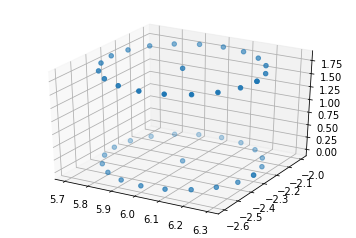

In [184]:
points = cil.get_points()

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2])

[0, 1920, 1080, 0]

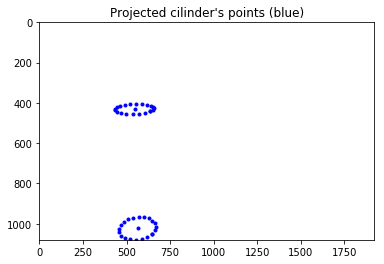

In [185]:
proj_points = camera.project_points(cil.get_points())

plt.figure()
plt.plot(proj_points[:,0], proj_points[:,1], 'b.')
_=plt.title("Projected cilinder's points (blue)")
plt.axis([0, 1920, 1080, 0])

[0, 1920, 1080, 0]

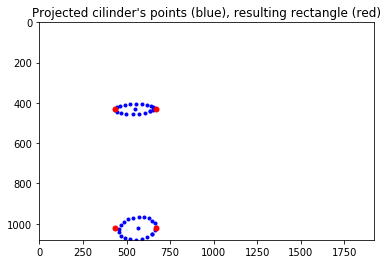

In [193]:
out = cil.project(camera)
rect = Rectangle(0, 0, *out) 
str(rect)

plt.figure()
plt.plot(proj_points[:,0], proj_points[:,1], 'b.')
plt.plot(rect.get_points()[:,0], rect.get_points()[:,1], 'r.', markersize=10)
_=plt.title("Projected cilinder's points (blue), resulting rectangle (red)")
plt.axis([0, 1920, 1080, 0])

In [52]:
world_grid = []
for i in range(NB_HEIGHT):
    for j in range(NB_WIDTH):
        step_width = WIDTH/NB_WIDTH
        step_height = HEIGHT/NB_HEIGHT
        world_grid.append([ORIGINE_X + j*step_width,
                           ORIGINE_Y + i*step_height,
                           0])   
world_grid = np.array(world_grid)        
        
for i, point in enumerate(world_grid):
    cil = Cilinder(MAN_RAY, MAN_HEIGHT, (point[0], point[1], 0))
    rect = Rectangle(camera.cam, i, *cil.project(camera)) 

    print(rect.to_string(1920, 1080, 0.2))


RECTANGLE 0 0 notvisible
RECTANGLE 0 1 notvisible
RECTANGLE 0 2 notvisible
RECTANGLE 0 3 notvisible
RECTANGLE 0 4 notvisible
RECTANGLE 0 5 notvisible
RECTANGLE 0 6 notvisible
RECTANGLE 0 7 notvisible
RECTANGLE 0 8 notvisible
RECTANGLE 0 9 notvisible
RECTANGLE 0 10 notvisible
RECTANGLE 0 11 notvisible
RECTANGLE 0 12 notvisible
RECTANGLE 0 13 notvisible
RECTANGLE 0 14 notvisible
RECTANGLE 0 15 notvisible
RECTANGLE 0 16 notvisible
RECTANGLE 0 17 notvisible
RECTANGLE 0 18 notvisible
RECTANGLE 0 19 notvisible
RECTANGLE 0 20 notvisible
RECTANGLE 0 21 notvisible
RECTANGLE 0 22 notvisible
RECTANGLE 0 23 notvisible
RECTANGLE 0 24 notvisible
RECTANGLE 0 25 notvisible
RECTANGLE 0 26 notvisible
RECTANGLE 0 27 notvisible
RECTANGLE 0 28 notvisible
RECTANGLE 0 29 notvisible
RECTANGLE 0 30 notvisible
RECTANGLE 0 31 notvisible
RECTANGLE 0 32 notvisible
RECTANGLE 0 33 notvisible
RECTANGLE 0 34 notvisible
RECTANGLE 0 35 notvisible
RECTANGLE 0 36 notvisible
RECTANGLE 0 37 notvisible
RECTANGLE 0 38 notvisi

RECTANGLE 0 365 notvisible
RECTANGLE 0 366 notvisible
RECTANGLE 0 367 notvisible
RECTANGLE 0 368 notvisible
RECTANGLE 0 369 notvisible
RECTANGLE 0 370 notvisible
RECTANGLE 0 371 notvisible
RECTANGLE 0 372 notvisible
RECTANGLE 0 373 notvisible
RECTANGLE 0 374 notvisible
RECTANGLE 0 375 notvisible
RECTANGLE 0 376 notvisible
RECTANGLE 0 377 notvisible
RECTANGLE 0 378 notvisible
RECTANGLE 0 379 notvisible
RECTANGLE 0 380 notvisible
RECTANGLE 0 381 notvisible
RECTANGLE 0 382 notvisible
RECTANGLE 0 383 notvisible
RECTANGLE 0 384 notvisible
RECTANGLE 0 385 notvisible
RECTANGLE 0 386 notvisible
RECTANGLE 0 387 notvisible
RECTANGLE 0 388 notvisible
RECTANGLE 0 389 notvisible
RECTANGLE 0 390 notvisible
RECTANGLE 0 391 notvisible
RECTANGLE 0 392 notvisible
RECTANGLE 0 393 notvisible
RECTANGLE 0 394 notvisible
RECTANGLE 0 395 notvisible
RECTANGLE 0 396 notvisible
RECTANGLE 0 397 notvisible
RECTANGLE 0 398 notvisible
RECTANGLE 0 399 notvisible
RECTANGLE 0 400 notvisible
RECTANGLE 0 401 notvisible
R

RECTANGLE 0 795 notvisible
RECTANGLE 0 796 notvisible
RECTANGLE 0 797 notvisible
RECTANGLE 0 798 notvisible
RECTANGLE 0 799 notvisible
RECTANGLE 0 800 notvisible
RECTANGLE 0 801 notvisible
RECTANGLE 0 802 notvisible
RECTANGLE 0 803 notvisible
RECTANGLE 0 804 notvisible
RECTANGLE 0 805 notvisible
RECTANGLE 0 806 notvisible
RECTANGLE 0 807 notvisible
RECTANGLE 0 808 notvisible
RECTANGLE 0 809 notvisible
RECTANGLE 0 810 notvisible
RECTANGLE 0 811 notvisible
RECTANGLE 0 812 notvisible
RECTANGLE 0 813 notvisible
RECTANGLE 0 814 notvisible
RECTANGLE 0 815 notvisible
RECTANGLE 0 816 notvisible
RECTANGLE 0 817 notvisible
RECTANGLE 0 818 notvisible
RECTANGLE 0 819 notvisible
RECTANGLE 0 820 notvisible
RECTANGLE 0 821 notvisible
RECTANGLE 0 822 notvisible
RECTANGLE 0 823 notvisible
RECTANGLE 0 824 notvisible
RECTANGLE 0 825 notvisible
RECTANGLE 0 826 notvisible
RECTANGLE 0 827 notvisible
RECTANGLE 0 828 notvisible
RECTANGLE 0 829 notvisible
RECTANGLE 0 830 notvisible
RECTANGLE 0 831 notvisible
R

RECTANGLE 0 1226 notvisible
RECTANGLE 0 1227 notvisible
RECTANGLE 0 1228 notvisible
RECTANGLE 0 1229 notvisible
RECTANGLE 0 1230 notvisible
RECTANGLE 0 1231 notvisible
RECTANGLE 0 1232 notvisible
RECTANGLE 0 1233 notvisible
RECTANGLE 0 1234 notvisible
RECTANGLE 0 1235 notvisible
RECTANGLE 0 1236 notvisible
RECTANGLE 0 1237 notvisible
RECTANGLE 0 1238 notvisible
RECTANGLE 0 1239 notvisible
RECTANGLE 0 1240 notvisible
RECTANGLE 0 1241 notvisible
RECTANGLE 0 1242 notvisible
RECTANGLE 0 1243 notvisible
RECTANGLE 0 1244 notvisible
RECTANGLE 0 1245 notvisible
RECTANGLE 0 1246 notvisible
RECTANGLE 0 1247 notvisible
RECTANGLE 0 1248 notvisible
RECTANGLE 0 1249 notvisible
RECTANGLE 0 1250 notvisible
RECTANGLE 0 1251 notvisible
RECTANGLE 0 1252 notvisible
RECTANGLE 0 1253 notvisible
RECTANGLE 0 1254 notvisible
RECTANGLE 0 1255 notvisible
RECTANGLE 0 1256 notvisible
RECTANGLE 0 1257 notvisible
RECTANGLE 0 1258 notvisible
RECTANGLE 0 1259 notvisible
RECTANGLE 0 1260 notvisible
RECTANGLE 0 1261 not

RECTANGLE 0 1632 notvisible
RECTANGLE 0 1633 notvisible
RECTANGLE 0 1634 notvisible
RECTANGLE 0 1635 notvisible
RECTANGLE 0 1636 notvisible
RECTANGLE 0 1637 notvisible
RECTANGLE 0 1638 notvisible
RECTANGLE 0 1639 notvisible
RECTANGLE 0 1640 notvisible
RECTANGLE 0 1641 notvisible
RECTANGLE 0 1642 notvisible
RECTANGLE 0 1643 notvisible
RECTANGLE 0 1644 notvisible
RECTANGLE 0 1645 notvisible
RECTANGLE 0 1646 notvisible
RECTANGLE 0 1647 notvisible
RECTANGLE 0 1648 notvisible
RECTANGLE 0 1649 notvisible
RECTANGLE 0 1650 notvisible
RECTANGLE 0 1651 notvisible
RECTANGLE 0 1652 notvisible
RECTANGLE 0 1653 notvisible
RECTANGLE 0 1654 notvisible
RECTANGLE 0 1655 notvisible
RECTANGLE 0 1656 notvisible
RECTANGLE 0 1657 notvisible
RECTANGLE 0 1658 notvisible
RECTANGLE 0 1659 notvisible
RECTANGLE 0 1660 notvisible
RECTANGLE 0 1661 notvisible
RECTANGLE 0 1662 notvisible
RECTANGLE 0 1663 notvisible
RECTANGLE 0 1664 notvisible
RECTANGLE 0 1665 notvisible
RECTANGLE 0 1666 notvisible
RECTANGLE 0 1667 not

RECTANGLE 0 1994 notvisible
RECTANGLE 0 1995 notvisible
RECTANGLE 0 1996 notvisible
RECTANGLE 0 1997 notvisible
RECTANGLE 0 1998 notvisible
RECTANGLE 0 1999 notvisible
RECTANGLE 0 2000 notvisible
RECTANGLE 0 2001 notvisible
RECTANGLE 0 2002 notvisible
RECTANGLE 0 2003 notvisible
RECTANGLE 0 2004 notvisible
RECTANGLE 0 2005 notvisible
RECTANGLE 0 2006 notvisible
RECTANGLE 0 2007 notvisible
RECTANGLE 0 2008 notvisible
RECTANGLE 0 2009 notvisible
RECTANGLE 0 2010 notvisible
RECTANGLE 0 2011 notvisible
RECTANGLE 0 2012 notvisible
RECTANGLE 0 2013 notvisible
RECTANGLE 0 2014 notvisible
RECTANGLE 0 2015 notvisible
RECTANGLE 0 2016 notvisible
RECTANGLE 0 2017 notvisible
RECTANGLE 0 2018 notvisible
RECTANGLE 0 2019 notvisible
RECTANGLE 0 2020 notvisible
RECTANGLE 0 2021 notvisible
RECTANGLE 0 2022 notvisible
RECTANGLE 0 2023 notvisible
RECTANGLE 0 2024 notvisible
RECTANGLE 0 2025 notvisible
RECTANGLE 0 2026 notvisible
RECTANGLE 0 2027 notvisible
RECTANGLE 0 2028 notvisible
RECTANGLE 0 2029 not

RECTANGLE 0 2397 notvisible
RECTANGLE 0 2398 notvisible
RECTANGLE 0 2399 notvisible
RECTANGLE 0 2400 notvisible
RECTANGLE 0 2401 notvisible
RECTANGLE 0 2402 notvisible
RECTANGLE 0 2403 notvisible
RECTANGLE 0 2404 notvisible
RECTANGLE 0 2405 notvisible
RECTANGLE 0 2406 notvisible
RECTANGLE 0 2407 notvisible
RECTANGLE 0 2408 notvisible
RECTANGLE 0 2409 notvisible
RECTANGLE 0 2410 notvisible
RECTANGLE 0 2411 notvisible
RECTANGLE 0 2412 notvisible
RECTANGLE 0 2413 notvisible
RECTANGLE 0 2414 notvisible
RECTANGLE 0 2415 notvisible
RECTANGLE 0 2416 notvisible
RECTANGLE 0 2417 notvisible
RECTANGLE 0 2418 notvisible
RECTANGLE 0 2419 notvisible
RECTANGLE 0 2420 notvisible
RECTANGLE 0 2421 notvisible
RECTANGLE 0 2422 notvisible
RECTANGLE 0 2423 notvisible
RECTANGLE 0 2424 notvisible
RECTANGLE 0 2425 notvisible
RECTANGLE 0 2426 notvisible
RECTANGLE 0 2427 notvisible
RECTANGLE 0 2428 notvisible
RECTANGLE 0 2429 notvisible
RECTANGLE 0 2430 notvisible
RECTANGLE 0 2431 notvisible
RECTANGLE 0 2432 not

RECTANGLE 0 2822 notvisible
RECTANGLE 0 2823 notvisible
RECTANGLE 0 2824 notvisible
RECTANGLE 0 2825 notvisible
RECTANGLE 0 2826 notvisible
RECTANGLE 0 2827 notvisible
RECTANGLE 0 2828 notvisible
RECTANGLE 0 2829 notvisible
RECTANGLE 0 2830 notvisible
RECTANGLE 0 2831 notvisible
RECTANGLE 0 2832 notvisible
RECTANGLE 0 2833 notvisible
RECTANGLE 0 2834 notvisible
RECTANGLE 0 2835 notvisible
RECTANGLE 0 2836 notvisible
RECTANGLE 0 2837 notvisible
RECTANGLE 0 2838 notvisible
RECTANGLE 0 2839 notvisible
RECTANGLE 0 2840 notvisible
RECTANGLE 0 2841 notvisible
RECTANGLE 0 2842 notvisible
RECTANGLE 0 2843 notvisible
RECTANGLE 0 2844 notvisible
RECTANGLE 0 2845 notvisible
RECTANGLE 0 2846 notvisible
RECTANGLE 0 2847 notvisible
RECTANGLE 0 2848 notvisible
RECTANGLE 0 2849 notvisible
RECTANGLE 0 2850 notvisible
RECTANGLE 0 2851 notvisible
RECTANGLE 0 2852 notvisible
RECTANGLE 0 2853 notvisible
RECTANGLE 0 2854 notvisible
RECTANGLE 0 2855 notvisible
RECTANGLE 0 2856 notvisible
RECTANGLE 0 2857 not

RECTANGLE 0 3202 notvisible
RECTANGLE 0 3203 notvisible
RECTANGLE 0 3204 notvisible
RECTANGLE 0 3205 notvisible
RECTANGLE 0 3206 notvisible
RECTANGLE 0 3207 notvisible
RECTANGLE 0 3208 notvisible
RECTANGLE 0 3209 notvisible
RECTANGLE 0 3210 notvisible
RECTANGLE 0 3211 notvisible
RECTANGLE 0 3212 notvisible
RECTANGLE 0 3213 notvisible
RECTANGLE 0 3214 notvisible
RECTANGLE 0 3215 notvisible
RECTANGLE 0 3216 notvisible
RECTANGLE 0 3217 notvisible
RECTANGLE 0 3218 notvisible
RECTANGLE 0 3219 notvisible
RECTANGLE 0 3220 notvisible
RECTANGLE 0 3221 notvisible
RECTANGLE 0 3222 notvisible
RECTANGLE 0 3223 notvisible
RECTANGLE 0 3224 notvisible
RECTANGLE 0 3225 notvisible
RECTANGLE 0 3226 notvisible
RECTANGLE 0 3227 notvisible
RECTANGLE 0 3228 notvisible
RECTANGLE 0 3229 notvisible
RECTANGLE 0 3230 notvisible
RECTANGLE 0 3231 notvisible
RECTANGLE 0 3232 notvisible
RECTANGLE 0 3233 notvisible
RECTANGLE 0 3234 notvisible
RECTANGLE 0 3235 notvisible
RECTANGLE 0 3236 notvisible
RECTANGLE 0 3237 not

RECTANGLE 0 3633 notvisible
RECTANGLE 0 3634 notvisible
RECTANGLE 0 3635 notvisible
RECTANGLE 0 3636 notvisible
RECTANGLE 0 3637 notvisible
RECTANGLE 0 3638 notvisible
RECTANGLE 0 3639 notvisible
RECTANGLE 0 3640 notvisible
RECTANGLE 0 3641 notvisible
RECTANGLE 0 3642 notvisible
RECTANGLE 0 3643 notvisible
RECTANGLE 0 3644 notvisible
RECTANGLE 0 3645 notvisible
RECTANGLE 0 3646 notvisible
RECTANGLE 0 3647 notvisible
RECTANGLE 0 3648 notvisible
RECTANGLE 0 3649 notvisible
RECTANGLE 0 3650 notvisible
RECTANGLE 0 3651 notvisible
RECTANGLE 0 3652 notvisible
RECTANGLE 0 3653 notvisible
RECTANGLE 0 3654 notvisible
RECTANGLE 0 3655 notvisible
RECTANGLE 0 3656 notvisible
RECTANGLE 0 3657 notvisible
RECTANGLE 0 3658 notvisible
RECTANGLE 0 3659 notvisible
RECTANGLE 0 3660 notvisible
RECTANGLE 0 3661 notvisible
RECTANGLE 0 3662 notvisible
RECTANGLE 0 3663 notvisible
RECTANGLE 0 3664 notvisible
RECTANGLE 0 3665 notvisible
RECTANGLE 0 3666 notvisible
RECTANGLE 0 3667 notvisible
RECTANGLE 0 3668 not

RECTANGLE 0 4087 notvisible
RECTANGLE 0 4088 notvisible
RECTANGLE 0 4089 notvisible
RECTANGLE 0 4090 notvisible
RECTANGLE 0 4091 notvisible
RECTANGLE 0 4092 notvisible
RECTANGLE 0 4093 notvisible
RECTANGLE 0 4094 notvisible
RECTANGLE 0 4095 notvisible
RECTANGLE 0 4096 notvisible
RECTANGLE 0 4097 notvisible
RECTANGLE 0 4098 notvisible
RECTANGLE 0 4099 notvisible
RECTANGLE 0 4100 notvisible
RECTANGLE 0 4101 notvisible
RECTANGLE 0 4102 notvisible
RECTANGLE 0 4103 notvisible
RECTANGLE 0 4104 notvisible
RECTANGLE 0 4105 notvisible
RECTANGLE 0 4106 notvisible
RECTANGLE 0 4107 notvisible
RECTANGLE 0 4108 notvisible
RECTANGLE 0 4109 notvisible
RECTANGLE 0 4110 notvisible
RECTANGLE 0 4111 notvisible
RECTANGLE 0 4112 notvisible
RECTANGLE 0 4113 notvisible
RECTANGLE 0 4114 notvisible
RECTANGLE 0 4115 notvisible
RECTANGLE 0 4116 notvisible
RECTANGLE 0 4117 notvisible
RECTANGLE 0 4118 notvisible
RECTANGLE 0 4119 notvisible
RECTANGLE 0 4120 notvisible
RECTANGLE 0 4121 notvisible
RECTANGLE 0 4122 not

RECTANGLE 0 4542 notvisible
RECTANGLE 0 4543 notvisible
RECTANGLE 0 4544 notvisible
RECTANGLE 0 4545 notvisible
RECTANGLE 0 4546 notvisible
RECTANGLE 0 4547 notvisible
RECTANGLE 0 4548 notvisible
RECTANGLE 0 4549 notvisible
RECTANGLE 0 4550 notvisible
RECTANGLE 0 4551 notvisible
RECTANGLE 0 4552 notvisible
RECTANGLE 0 4553 notvisible
RECTANGLE 0 4554 notvisible
RECTANGLE 0 4555 notvisible
RECTANGLE 0 4556 notvisible
RECTANGLE 0 4557 notvisible
RECTANGLE 0 4558 notvisible
RECTANGLE 0 4559 notvisible
RECTANGLE 0 4560 notvisible
RECTANGLE 0 4561 notvisible
RECTANGLE 0 4562 notvisible
RECTANGLE 0 4563 notvisible
RECTANGLE 0 4564 notvisible
RECTANGLE 0 4565 notvisible
RECTANGLE 0 4566 notvisible
RECTANGLE 0 4567 notvisible
RECTANGLE 0 4568 notvisible
RECTANGLE 0 4569 notvisible
RECTANGLE 0 4570 notvisible
RECTANGLE 0 4571 notvisible
RECTANGLE 0 4572 notvisible
RECTANGLE 0 4573 notvisible
RECTANGLE 0 4574 notvisible
RECTANGLE 0 4575 notvisible
RECTANGLE 0 4576 notvisible
RECTANGLE 0 4577 not

RECTANGLE 0 4927 notvisible
RECTANGLE 0 4928 notvisible
RECTANGLE 0 4929 notvisible
RECTANGLE 0 4930 notvisible
RECTANGLE 0 4931 notvisible
RECTANGLE 0 4932 notvisible
RECTANGLE 0 4933 notvisible
RECTANGLE 0 4934 notvisible
RECTANGLE 0 4935 notvisible
RECTANGLE 0 4936 notvisible
RECTANGLE 0 4937 notvisible
RECTANGLE 0 4938 notvisible
RECTANGLE 0 4939 notvisible
RECTANGLE 0 4940 notvisible
RECTANGLE 0 4941 notvisible
RECTANGLE 0 4942 notvisible
RECTANGLE 0 4943 notvisible
RECTANGLE 0 4944 notvisible
RECTANGLE 0 4945 notvisible
RECTANGLE 0 4946 notvisible
RECTANGLE 0 4947 notvisible
RECTANGLE 0 4948 notvisible
RECTANGLE 0 4949 notvisible
RECTANGLE 0 4950 notvisible
RECTANGLE 0 4951 notvisible
RECTANGLE 0 4952 notvisible
RECTANGLE 0 4953 notvisible
RECTANGLE 0 4954 notvisible
RECTANGLE 0 4955 notvisible
RECTANGLE 0 4956 notvisible
RECTANGLE 0 4957 notvisible
RECTANGLE 0 4958 notvisible
RECTANGLE 0 4959 notvisible
RECTANGLE 0 4960 notvisible
RECTANGLE 0 4961 notvisible
RECTANGLE 0 4962 not

RECTANGLE 0 5266 notvisible
RECTANGLE 0 5267 notvisible
RECTANGLE 0 5268 notvisible
RECTANGLE 0 5269 notvisible
RECTANGLE 0 5270 notvisible
RECTANGLE 0 5271 notvisible
RECTANGLE 0 5272 notvisible
RECTANGLE 0 5273 notvisible
RECTANGLE 0 5274 notvisible
RECTANGLE 0 5275 notvisible
RECTANGLE 0 5276 notvisible
RECTANGLE 0 5277 notvisible
RECTANGLE 0 5278 notvisible
RECTANGLE 0 5279 notvisible
RECTANGLE 0 5280 notvisible
RECTANGLE 0 5281 notvisible
RECTANGLE 0 5282 notvisible
RECTANGLE 0 5283 notvisible
RECTANGLE 0 5284 notvisible
RECTANGLE 0 5285 notvisible
RECTANGLE 0 5286 notvisible
RECTANGLE 0 5287 notvisible
RECTANGLE 0 5288 notvisible
RECTANGLE 0 5289 notvisible
RECTANGLE 0 5290 notvisible
RECTANGLE 0 5291 notvisible
RECTANGLE 0 5292 notvisible
RECTANGLE 0 5293 notvisible
RECTANGLE 0 5294 notvisible
RECTANGLE 0 5295 notvisible
RECTANGLE 0 5296 notvisible
RECTANGLE 0 5297 notvisible
RECTANGLE 0 5298 notvisible
RECTANGLE 0 5299 notvisible
RECTANGLE 0 5300 notvisible
RECTANGLE 0 5301 not

RECTANGLE 0 5613 notvisible
RECTANGLE 0 5614 notvisible
RECTANGLE 0 5615 notvisible
RECTANGLE 0 5616 notvisible
RECTANGLE 0 5617 notvisible
RECTANGLE 0 5618 notvisible
RECTANGLE 0 5619 notvisible
RECTANGLE 0 5620 notvisible
RECTANGLE 0 5621 notvisible
RECTANGLE 0 5622 notvisible
RECTANGLE 0 5623 notvisible
RECTANGLE 0 5624 notvisible
RECTANGLE 0 5625 notvisible
RECTANGLE 0 5626 notvisible
RECTANGLE 0 5627 notvisible
RECTANGLE 0 5628 notvisible
RECTANGLE 0 5629 notvisible
RECTANGLE 0 5630 notvisible
RECTANGLE 0 5631 notvisible
RECTANGLE 0 5632 notvisible
RECTANGLE 0 5633 notvisible
RECTANGLE 0 5634 notvisible
RECTANGLE 0 5635 notvisible
RECTANGLE 0 5636 notvisible
RECTANGLE 0 5637 notvisible
RECTANGLE 0 5638 notvisible
RECTANGLE 0 5639 notvisible
RECTANGLE 0 5640 notvisible
RECTANGLE 0 5641 notvisible
RECTANGLE 0 5642 notvisible
RECTANGLE 0 5643 notvisible
RECTANGLE 0 5644 notvisible
RECTANGLE 0 5645 notvisible
RECTANGLE 0 5646 notvisible
RECTANGLE 0 5647 notvisible
RECTANGLE 0 5648 not

RECTANGLE 0 6047 notvisible
RECTANGLE 0 6048 notvisible
RECTANGLE 0 6049 notvisible
RECTANGLE 0 6050 notvisible
RECTANGLE 0 6051 notvisible
RECTANGLE 0 6052 notvisible
RECTANGLE 0 6053 notvisible
RECTANGLE 0 6054 notvisible
RECTANGLE 0 6055 notvisible
RECTANGLE 0 6056 notvisible
RECTANGLE 0 6057 notvisible
RECTANGLE 0 6058 notvisible
RECTANGLE 0 6059 notvisible
RECTANGLE 0 6060 notvisible
RECTANGLE 0 6061 notvisible
RECTANGLE 0 6062 notvisible
RECTANGLE 0 6063 notvisible
RECTANGLE 0 6064 notvisible
RECTANGLE 0 6065 notvisible
RECTANGLE 0 6066 notvisible
RECTANGLE 0 6067 notvisible
RECTANGLE 0 6068 notvisible
RECTANGLE 0 6069 notvisible
RECTANGLE 0 6070 notvisible
RECTANGLE 0 6071 notvisible
RECTANGLE 0 6072 notvisible
RECTANGLE 0 6073 notvisible
RECTANGLE 0 6074 notvisible
RECTANGLE 0 6075 notvisible
RECTANGLE 0 6076 notvisible
RECTANGLE 0 6077 notvisible
RECTANGLE 0 6078 notvisible
RECTANGLE 0 6079 notvisible
RECTANGLE 0 6080 notvisible
RECTANGLE 0 6081 notvisible
RECTANGLE 0 6082 not

RECTANGLE 0 6498 notvisible
RECTANGLE 0 6499 notvisible
RECTANGLE 0 6500 notvisible
RECTANGLE 0 6501 notvisible
RECTANGLE 0 6502 notvisible
RECTANGLE 0 6503 notvisible
RECTANGLE 0 6504 notvisible
RECTANGLE 0 6505 notvisible
RECTANGLE 0 6506 notvisible
RECTANGLE 0 6507 notvisible
RECTANGLE 0 6508 notvisible
RECTANGLE 0 6509 notvisible
RECTANGLE 0 6510 notvisible
RECTANGLE 0 6511 notvisible
RECTANGLE 0 6512 notvisible
RECTANGLE 0 6513 notvisible
RECTANGLE 0 6514 notvisible
RECTANGLE 0 6515 notvisible
RECTANGLE 0 6516 notvisible
RECTANGLE 0 6517 notvisible
RECTANGLE 0 6518 notvisible
RECTANGLE 0 6519 notvisible
RECTANGLE 0 6520 notvisible
RECTANGLE 0 6521 notvisible
RECTANGLE 0 6522 notvisible
RECTANGLE 0 6523 notvisible
RECTANGLE 0 6524 notvisible
RECTANGLE 0 6525 notvisible
RECTANGLE 0 6526 notvisible
RECTANGLE 0 6527 notvisible
RECTANGLE 0 6528 notvisible
RECTANGLE 0 6529 notvisible
RECTANGLE 0 6530 notvisible
RECTANGLE 0 6531 notvisible
RECTANGLE 0 6532 notvisible
RECTANGLE 0 6533 not

RECTANGLE 0 6886 notvisible
RECTANGLE 0 6887 notvisible
RECTANGLE 0 6888 notvisible
RECTANGLE 0 6889 notvisible
RECTANGLE 0 6890 notvisible
RECTANGLE 0 6891 notvisible
RECTANGLE 0 6892 notvisible
RECTANGLE 0 6893 notvisible
RECTANGLE 0 6894 notvisible
RECTANGLE 0 6895 notvisible
RECTANGLE 0 6896 notvisible
RECTANGLE 0 6897 notvisible
RECTANGLE 0 6898 notvisible
RECTANGLE 0 6899 notvisible
RECTANGLE 0 6900 notvisible
RECTANGLE 0 6901 notvisible
RECTANGLE 0 6902 notvisible
RECTANGLE 0 6903 notvisible
RECTANGLE 0 6904 notvisible
RECTANGLE 0 6905 notvisible
RECTANGLE 0 6906 notvisible
RECTANGLE 0 6907 notvisible
RECTANGLE 0 6908 notvisible
RECTANGLE 0 6909 notvisible
RECTANGLE 0 6910 notvisible
RECTANGLE 0 6911 notvisible
RECTANGLE 0 6912 notvisible
RECTANGLE 0 6913 notvisible
RECTANGLE 0 6914 notvisible
RECTANGLE 0 6915 notvisible
RECTANGLE 0 6916 notvisible
RECTANGLE 0 6917 notvisible
RECTANGLE 0 6918 notvisible
RECTANGLE 0 6919 notvisible
RECTANGLE 0 6920 notvisible
RECTANGLE 0 6921 not

RECTANGLE 0 7275 notvisible
RECTANGLE 0 7276 notvisible
RECTANGLE 0 7277 notvisible
RECTANGLE 0 7278 notvisible
RECTANGLE 0 7279 notvisible
RECTANGLE 0 7280 notvisible
RECTANGLE 0 7281 notvisible
RECTANGLE 0 7282 notvisible
RECTANGLE 0 7283 notvisible
RECTANGLE 0 7284 notvisible
RECTANGLE 0 7285 notvisible
RECTANGLE 0 7286 notvisible
RECTANGLE 0 7287 notvisible
RECTANGLE 0 7288 notvisible
RECTANGLE 0 7289 notvisible
RECTANGLE 0 7290 notvisible
RECTANGLE 0 7291 notvisible
RECTANGLE 0 7292 notvisible
RECTANGLE 0 7293 notvisible
RECTANGLE 0 7294 notvisible
RECTANGLE 0 7295 notvisible
RECTANGLE 0 7296 notvisible
RECTANGLE 0 7297 notvisible
RECTANGLE 0 7298 notvisible
RECTANGLE 0 7299 notvisible
RECTANGLE 0 7300 notvisible
RECTANGLE 0 7301 notvisible
RECTANGLE 0 7302 notvisible
RECTANGLE 0 7303 notvisible
RECTANGLE 0 7304 notvisible
RECTANGLE 0 7305 notvisible
RECTANGLE 0 7306 notvisible
RECTANGLE 0 7307 notvisible
RECTANGLE 0 7308 notvisible
RECTANGLE 0 7309 notvisible
RECTANGLE 0 7310 not

RECTANGLE 0 7658 notvisible
RECTANGLE 0 7659 notvisible
RECTANGLE 0 7660 notvisible
RECTANGLE 0 7661 notvisible
RECTANGLE 0 7662 notvisible
RECTANGLE 0 7663 notvisible
RECTANGLE 0 7664 notvisible
RECTANGLE 0 7665 notvisible
RECTANGLE 0 7666 notvisible
RECTANGLE 0 7667 notvisible
RECTANGLE 0 7668 notvisible
RECTANGLE 0 7669 notvisible
RECTANGLE 0 7670 notvisible
RECTANGLE 0 7671 notvisible
RECTANGLE 0 7672 notvisible
RECTANGLE 0 7673 notvisible
RECTANGLE 0 7674 notvisible
RECTANGLE 0 7675 notvisible
RECTANGLE 0 7676 notvisible
RECTANGLE 0 7677 notvisible
RECTANGLE 0 7678 notvisible
RECTANGLE 0 7679 notvisible
RECTANGLE 0 7680 notvisible
RECTANGLE 0 7681 notvisible
RECTANGLE 0 7682 notvisible
RECTANGLE 0 7683 notvisible
RECTANGLE 0 7684 notvisible
RECTANGLE 0 7685 notvisible
RECTANGLE 0 7686 notvisible
RECTANGLE 0 7687 notvisible
RECTANGLE 0 7688 notvisible
RECTANGLE 0 7689 notvisible
RECTANGLE 0 7690 notvisible
RECTANGLE 0 7691 notvisible
RECTANGLE 0 7692 notvisible
RECTANGLE 0 7693 not

RECTANGLE 0 8001 notvisible
RECTANGLE 0 8002 notvisible
RECTANGLE 0 8003 notvisible
RECTANGLE 0 8004 notvisible
RECTANGLE 0 8005 notvisible
RECTANGLE 0 8006 notvisible
RECTANGLE 0 8007 notvisible
RECTANGLE 0 8008 notvisible
RECTANGLE 0 8009 notvisible
RECTANGLE 0 8010 notvisible
RECTANGLE 0 8011 notvisible
RECTANGLE 0 8012 notvisible
RECTANGLE 0 8013 notvisible
RECTANGLE 0 8014 notvisible
RECTANGLE 0 8015 notvisible
RECTANGLE 0 8016 notvisible
RECTANGLE 0 8017 notvisible
RECTANGLE 0 8018 notvisible
RECTANGLE 0 8019 notvisible
RECTANGLE 0 8020 notvisible
RECTANGLE 0 8021 notvisible
RECTANGLE 0 8022 notvisible
RECTANGLE 0 8023 notvisible
RECTANGLE 0 8024 notvisible
RECTANGLE 0 8025 notvisible
RECTANGLE 0 8026 notvisible
RECTANGLE 0 8027 notvisible
RECTANGLE 0 8028 notvisible
RECTANGLE 0 8029 notvisible
RECTANGLE 0 8030 notvisible
RECTANGLE 0 8031 notvisible
RECTANGLE 0 8032 notvisible
RECTANGLE 0 8033 notvisible
RECTANGLE 0 8034 notvisible
RECTANGLE 0 8035 notvisible
RECTANGLE 0 8036 not

RECTANGLE 0 8408 57.816329028872474 432.19542991804406 108.950031410924
RECTANGLE 0 8409 64.47768825722142 433.7751350223813 116.00376833141286
RECTANGLE 0 8410 71.24399472032655 435.37335333929053 123.14762806840827
RECTANGLE 0 8411 78.11538411424578 436.99029128285594 130.38226452332492
RECTANGLE 0 8412 85.0920480465013 438.6261626046764 137.7083813802907
RECTANGLE 0 8413 92.17423561668977 440.2811883598515 145.1267327371164
RECTANGLE 0 8414 99.36225497256635 441.95559685812594 152.6381236820763
RECTANGLE 0 8415 106.6564748368911 443.6496235993506 160.24341081213197
RECTANGLE 0 8416 114.05732600003284 445.36351119239913 167.9435026880725
RECTANGLE 0 8417 121.56530277304819 447.09750925665224 175.739360221855
RECTANGLE 0 8418 129.18096439563453 448.85187430514424 183.63199699126687
RECTANGLE 0 8419 136.90493639305691 450.6268696084442 191.62247947684784
RECTANGLE 0 8420 144.73791187582867 452.42276503832477 199.711927215841
RECTANGLE 0 8421 notvisible
RECTANGLE 0 8422 notvisible
RECTA

RECTANGLE 0 8845 notvisible
RECTANGLE 0 8846 notvisible
RECTANGLE 0 8847 notvisible
RECTANGLE 0 8848 notvisible
RECTANGLE 0 8849 notvisible
RECTANGLE 0 8850 notvisible
RECTANGLE 0 8851 notvisible
RECTANGLE 0 8852 notvisible
RECTANGLE 0 8853 notvisible
RECTANGLE 0 8854 notvisible
RECTANGLE 0 8855 notvisible
RECTANGLE 0 8856 notvisible
RECTANGLE 0 8857 notvisible
RECTANGLE 0 8858 notvisible
RECTANGLE 0 8859 notvisible
RECTANGLE 0 8860 notvisible
RECTANGLE 0 8861 notvisible
RECTANGLE 0 8862 notvisible
RECTANGLE 0 8863 notvisible
RECTANGLE 0 8864 notvisible
RECTANGLE 0 8865 notvisible
RECTANGLE 0 8866 notvisible
RECTANGLE 0 8867 notvisible
RECTANGLE 0 8868 notvisible
RECTANGLE 0 8869 notvisible
RECTANGLE 0 8870 notvisible
RECTANGLE 0 8871 notvisible
RECTANGLE 0 8872 notvisible
RECTANGLE 0 8873 notvisible
RECTANGLE 0 8874 notvisible
RECTANGLE 0 8875 notvisible
RECTANGLE 0 8876 notvisible
RECTANGLE 0 8877 notvisible
RECTANGLE 0 8878 notvisible
RECTANGLE 0 8879 notvisible
RECTANGLE 0 8880 50.

RECTANGLE 0 9239 notvisible
RECTANGLE 0 9240 81.13313799325351 402.82732854118694 127.70126288368192
RECTANGLE 0 9241 87.48715751054613 404.1474420295362 134.35153239818487
RECTANGLE 0 9242 93.9285955182844 405.48232180239484 141.07864871326524
RECTANGLE 0 9243 100.45767959358875 406.832115056836 147.8831967950034
RECTANGLE 0 9244 107.07467837284707 408.1969743572169 154.76579784535545
RECTANGLE 0 9245 113.77990247405876 409.5770576283508 161.72710964829844
RECTANGLE 0 9246 120.57370539731619 410.9725281403035 168.76782687892933
RECTANGLE 0 9247 127.4564844005954 412.38355448435965 175.88868137295447
RECTANGLE 0 9248 134.42868134789285 413.8103105396925 183.0904423539215
RECTANGLE 0 9249 141.4907835265858 415.2529754302583 190.3739166154587
RECTANGLE 0 9250 148.64332443075568 416.71173347142474 197.7399486556942
RECTANGLE 0 9251 155.88688450704706 418.1867741058343 205.18942076094447
RECTANGLE 0 9252 163.22209185949418 419.6782918279889 212.7232530356672
RECTANGLE 0 9253 170.6496229095

RECTANGLE 0 9637 412.9548164136993 453.5738229804552 463.64003188655545
RECTANGLE 0 9638 423.0770570428941 455.48927189759775 473.84634018741406
RECTANGLE 0 9639 433.32293551959174 457.42624859475376 484.1714792799195
RECTANGLE 0 9640 443.6788838400243 459.38496760766117 494.616960380031
RECTANGLE 0 9641 notvisible
RECTANGLE 0 9642 notvisible
RECTANGLE 0 9643 notvisible
RECTANGLE 0 9644 notvisible
RECTANGLE 0 9645 notvisible
RECTANGLE 0 9646 notvisible
RECTANGLE 0 9647 notvisible
RECTANGLE 0 9648 notvisible
RECTANGLE 0 9649 notvisible
RECTANGLE 0 9650 notvisible
RECTANGLE 0 9651 notvisible
RECTANGLE 0 9652 notvisible
RECTANGLE 0 9653 notvisible
RECTANGLE 0 9654 notvisible
RECTANGLE 0 9655 notvisible
RECTANGLE 0 9656 notvisible
RECTANGLE 0 9657 notvisible
RECTANGLE 0 9658 notvisible
RECTANGLE 0 9659 notvisible
RECTANGLE 0 9660 notvisible
RECTANGLE 0 9661 notvisible
RECTANGLE 0 9662 notvisible
RECTANGLE 0 9663 notvisible
RECTANGLE 0 9664 notvisible
RECTANGLE 0 9665 notvisible
RECTANGLE 0

RECTANGLE 0 10054 notvisible
RECTANGLE 0 10055 notvisible
RECTANGLE 0 10056 notvisible
RECTANGLE 0 10057 notvisible
RECTANGLE 0 10058 notvisible
RECTANGLE 0 10059 notvisible
RECTANGLE 0 10060 notvisible
RECTANGLE 0 10061 notvisible
RECTANGLE 0 10062 notvisible
RECTANGLE 0 10063 notvisible
RECTANGLE 0 10064 notvisible
RECTANGLE 0 10065 notvisible
RECTANGLE 0 10066 notvisible
RECTANGLE 0 10067 notvisible
RECTANGLE 0 10068 notvisible
RECTANGLE 0 10069 notvisible
RECTANGLE 0 10070 notvisible
RECTANGLE 0 10071 notvisible
RECTANGLE 0 10072 notvisible
RECTANGLE 0 10073 notvisible
RECTANGLE 0 10074 notvisible
RECTANGLE 0 10075 notvisible
RECTANGLE 0 10076 notvisible
RECTANGLE 0 10077 notvisible
RECTANGLE 0 10078 notvisible
RECTANGLE 0 10079 notvisible
RECTANGLE 0 10080 151.9305620542126 386.75570064865093 196.2481363760728
RECTANGLE 0 10081 158.58793768194278 387.9699530112102 203.0802936008197
RECTANGLE 0 10082 165.3224998287278 389.19712903806914 209.98377009252056
RECTANGLE 0 10083 172.1347

RECTANGLE 0 10488 notvisible
RECTANGLE 0 10489 notvisible
RECTANGLE 0 10490 notvisible
RECTANGLE 0 10491 notvisible
RECTANGLE 0 10492 notvisible
RECTANGLE 0 10493 notvisible
RECTANGLE 0 10494 notvisible
RECTANGLE 0 10495 notvisible
RECTANGLE 0 10496 notvisible
RECTANGLE 0 10497 notvisible
RECTANGLE 0 10498 notvisible
RECTANGLE 0 10499 notvisible
RECTANGLE 0 10500 notvisible
RECTANGLE 0 10501 notvisible
RECTANGLE 0 10502 notvisible
RECTANGLE 0 10503 notvisible
RECTANGLE 0 10504 notvisible
RECTANGLE 0 10505 notvisible
RECTANGLE 0 10506 notvisible
RECTANGLE 0 10507 notvisible
RECTANGLE 0 10508 notvisible
RECTANGLE 0 10509 notvisible
RECTANGLE 0 10510 notvisible
RECTANGLE 0 10511 notvisible
RECTANGLE 0 10512 notvisible
RECTANGLE 0 10513 notvisible
RECTANGLE 0 10514 notvisible
RECTANGLE 0 10515 notvisible
RECTANGLE 0 10516 notvisible
RECTANGLE 0 10517 notvisible
RECTANGLE 0 10518 notvisible
RECTANGLE 0 10519 notvisible
RECTANGLE 0 10520 notvisible
RECTANGLE 0 10521 notvisible
RECTANGLE 0 10

RECTANGLE 0 10932 306.2661455791696 386.098234148144 349.0440016864884
RECTANGLE 0 10933 314.00817858087805 387.36488593715353 356.86025445021596
RECTANGLE 0 10934 321.8309794482584 388.644761722966 364.7546756430901
RECTANGLE 0 10935 329.7355135867166 389.93802226143674 372.72823733540235
RECTANGLE 0 10936 337.72276930955957 391.2448300838292 380.78192421050346
RECTANGLE 0 10937 345.79375724827116 392.56534935665326 388.9167327269539
RECTANGLE 0 10938 353.9495097036478 393.8997457333325 397.1336702289906
RECTANGLE 0 10939 362.1910799357579 395.24818619753523 405.4337540041695
RECTANGLE 0 10940 370.519541390702 396.61083889801506 413.818010287083
RECTANGLE 0 10941 378.9359868621599 397.98787297481647 422.2874732081168
RECTANGLE 0 10942 387.44152758573944 399.37945837671066 430.843726203747
RECTANGLE 0 10943 396.0372922641599 400.78576566974283 439.5173595325306
RECTANGLE 0 10944 404.72442602135095 402.20696583678364 448.27995943560774
RECTANGLE 0 10945 413.50408928358866 403.6432300679

RECTANGLE 0 11379 notvisible
RECTANGLE 0 11380 notvisible
RECTANGLE 0 11381 notvisible
RECTANGLE 0 11382 notvisible
RECTANGLE 0 11383 notvisible
RECTANGLE 0 11384 notvisible
RECTANGLE 0 11385 notvisible
RECTANGLE 0 11386 notvisible
RECTANGLE 0 11387 notvisible
RECTANGLE 0 11388 notvisible
RECTANGLE 0 11389 notvisible
RECTANGLE 0 11390 notvisible
RECTANGLE 0 11391 notvisible
RECTANGLE 0 11392 notvisible
RECTANGLE 0 11393 notvisible
RECTANGLE 0 11394 notvisible
RECTANGLE 0 11395 notvisible
RECTANGLE 0 11396 notvisible
RECTANGLE 0 11397 notvisible
RECTANGLE 0 11398 notvisible
RECTANGLE 0 11399 notvisible
RECTANGLE 0 11400 256.19289965884866 363.8637861438356 296.3408616918704
RECTANGLE 0 11401 263.1027548099513 364.93429166095564 303.3362889254645
RECTANGLE 0 11402 270.0812326595702 366.0155839061615 310.39776611778007
RECTANGLE 0 11403 277.1290298183252 367.10778860593916 317.52605516294716
RECTANGLE 0 11404 284.2468643244356 368.21103388776055 324.7219326925573
RECTANGLE 0 11405 291.435

RECTANGLE 0 11796 notvisible
RECTANGLE 0 11797 notvisible
RECTANGLE 0 11798 notvisible
RECTANGLE 0 11799 notvisible
RECTANGLE 0 11800 notvisible
RECTANGLE 0 11801 notvisible
RECTANGLE 0 11802 notvisible
RECTANGLE 0 11803 notvisible
RECTANGLE 0 11804 notvisible
RECTANGLE 0 11805 notvisible
RECTANGLE 0 11806 notvisible
RECTANGLE 0 11807 notvisible
RECTANGLE 0 11808 notvisible
RECTANGLE 0 11809 notvisible
RECTANGLE 0 11810 notvisible
RECTANGLE 0 11811 notvisible
RECTANGLE 0 11812 notvisible
RECTANGLE 0 11813 notvisible
RECTANGLE 0 11814 notvisible
RECTANGLE 0 11815 notvisible
RECTANGLE 0 11816 notvisible
RECTANGLE 0 11817 notvisible
RECTANGLE 0 11818 notvisible
RECTANGLE 0 11819 notvisible
RECTANGLE 0 11820 notvisible
RECTANGLE 0 11821 notvisible
RECTANGLE 0 11822 notvisible
RECTANGLE 0 11823 notvisible
RECTANGLE 0 11824 notvisible
RECTANGLE 0 11825 notvisible
RECTANGLE 0 11826 notvisible
RECTANGLE 0 11827 notvisible
RECTANGLE 0 11828 notvisible
RECTANGLE 0 11829 notvisible
RECTANGLE 0 11

RECTANGLE 0 12176 notvisible
RECTANGLE 0 12177 notvisible
RECTANGLE 0 12178 notvisible
RECTANGLE 0 12179 notvisible
RECTANGLE 0 12180 notvisible
RECTANGLE 0 12181 notvisible
RECTANGLE 0 12182 notvisible
RECTANGLE 0 12183 notvisible
RECTANGLE 0 12184 notvisible
RECTANGLE 0 12185 notvisible
RECTANGLE 0 12186 notvisible
RECTANGLE 0 12187 notvisible
RECTANGLE 0 12188 notvisible
RECTANGLE 0 12189 notvisible
RECTANGLE 0 12190 notvisible
RECTANGLE 0 12191 notvisible
RECTANGLE 0 12192 notvisible
RECTANGLE 0 12193 notvisible
RECTANGLE 0 12194 notvisible
RECTANGLE 0 12195 notvisible
RECTANGLE 0 12196 notvisible
RECTANGLE 0 12197 notvisible
RECTANGLE 0 12198 notvisible
RECTANGLE 0 12199 notvisible
RECTANGLE 0 12200 notvisible
RECTANGLE 0 12201 notvisible
RECTANGLE 0 12202 notvisible
RECTANGLE 0 12203 notvisible
RECTANGLE 0 12204 notvisible
RECTANGLE 0 12205 notvisible
RECTANGLE 0 12206 notvisible
RECTANGLE 0 12207 notvisible
RECTANGLE 0 12208 notvisible
RECTANGLE 0 12209 notvisible
RECTANGLE 0 12

RECTANGLE 0 12556 notvisible
RECTANGLE 0 12557 notvisible
RECTANGLE 0 12558 notvisible
RECTANGLE 0 12559 notvisible
RECTANGLE 0 12560 notvisible
RECTANGLE 0 12561 notvisible
RECTANGLE 0 12562 notvisible
RECTANGLE 0 12563 notvisible
RECTANGLE 0 12564 notvisible
RECTANGLE 0 12565 notvisible
RECTANGLE 0 12566 notvisible
RECTANGLE 0 12567 notvisible
RECTANGLE 0 12568 notvisible
RECTANGLE 0 12569 notvisible
RECTANGLE 0 12570 notvisible
RECTANGLE 0 12571 notvisible
RECTANGLE 0 12572 notvisible
RECTANGLE 0 12573 notvisible
RECTANGLE 0 12574 notvisible
RECTANGLE 0 12575 notvisible
RECTANGLE 0 12576 notvisible
RECTANGLE 0 12577 notvisible
RECTANGLE 0 12578 notvisible
RECTANGLE 0 12579 notvisible
RECTANGLE 0 12580 notvisible
RECTANGLE 0 12581 notvisible
RECTANGLE 0 12582 notvisible
RECTANGLE 0 12583 notvisible
RECTANGLE 0 12584 notvisible
RECTANGLE 0 12585 notvisible
RECTANGLE 0 12586 notvisible
RECTANGLE 0 12587 notvisible
RECTANGLE 0 12588 notvisible
RECTANGLE 0 12589 notvisible
RECTANGLE 0 12

RECTANGLE 0 12962 381.78541448867793 341.943972149042 417.4250945631795
RECTANGLE 0 12963 388.9483232750671 342.8953757172908 424.6258108060405
RECTANGLE 0 12964 396.1750036989423 343.8560784774114 431.88877066930917
RECTANGLE 0 12965 403.4661285495994 344.8261910825496 439.23303659962085
RECTANGLE 0 12966 410.82237839964364 345.80582533309337 446.64481081855985
RECTANGLE 0 12967 418.24444111621847 346.7950941085634 454.1211547774667
RECTANGLE 0 12968 425.73301134553463 347.7941112960379 461.6627246386826
RECTANGLE 0 12969 433.2887899702056 348.80299171505965 469.270177582589
RECTANGLE 0 12970 440.91206856286436 349.8218510389685 476.9441711755694
RECTANGLE 0 12971 448.58026225065146 350.8508057126134 484.6853627146242
RECTANGLE 0 12972 456.3173630351135 351.88997286639665 492.494408548528
RECTANGLE 0 12973 notvisible
RECTANGLE 0 12974 notvisible
RECTANGLE 0 12975 notvisible
RECTANGLE 0 12976 notvisible
RECTANGLE 0 12977 notvisible
RECTANGLE 0 12978 notvisible
RECTANGLE 0 12979 notvisi

RECTANGLE 0 13408 notvisible
RECTANGLE 0 13409 notvisible
RECTANGLE 0 13410 notvisible
RECTANGLE 0 13411 notvisible
RECTANGLE 0 13412 notvisible
RECTANGLE 0 13413 notvisible
RECTANGLE 0 13414 notvisible
RECTANGLE 0 13415 notvisible
RECTANGLE 0 13416 notvisible
RECTANGLE 0 13417 notvisible
RECTANGLE 0 13418 notvisible
RECTANGLE 0 13419 notvisible
RECTANGLE 0 13420 notvisible
RECTANGLE 0 13421 notvisible
RECTANGLE 0 13422 notvisible
RECTANGLE 0 13423 notvisible
RECTANGLE 0 13424 notvisible
RECTANGLE 0 13425 notvisible
RECTANGLE 0 13426 notvisible
RECTANGLE 0 13427 notvisible
RECTANGLE 0 13428 notvisible
RECTANGLE 0 13429 notvisible
RECTANGLE 0 13430 notvisible
RECTANGLE 0 13431 notvisible
RECTANGLE 0 13432 notvisible
RECTANGLE 0 13433 notvisible
RECTANGLE 0 13434 notvisible
RECTANGLE 0 13435 notvisible
RECTANGLE 0 13436 notvisible
RECTANGLE 0 13437 notvisible
RECTANGLE 0 13438 notvisible
RECTANGLE 0 13439 notvisible
RECTANGLE 0 13440 399.5068386398608 333.3802417682124 433.7949596009691


RECTANGLE 0 13843 notvisible
RECTANGLE 0 13844 notvisible
RECTANGLE 0 13845 notvisible
RECTANGLE 0 13846 notvisible
RECTANGLE 0 13847 notvisible
RECTANGLE 0 13848 notvisible
RECTANGLE 0 13849 notvisible
RECTANGLE 0 13850 notvisible
RECTANGLE 0 13851 notvisible
RECTANGLE 0 13852 notvisible
RECTANGLE 0 13853 notvisible
RECTANGLE 0 13854 notvisible
RECTANGLE 0 13855 notvisible
RECTANGLE 0 13856 notvisible
RECTANGLE 0 13857 notvisible
RECTANGLE 0 13858 notvisible
RECTANGLE 0 13859 notvisible
RECTANGLE 0 13860 notvisible
RECTANGLE 0 13861 notvisible
RECTANGLE 0 13862 notvisible
RECTANGLE 0 13863 notvisible
RECTANGLE 0 13864 notvisible
RECTANGLE 0 13865 notvisible
RECTANGLE 0 13866 notvisible
RECTANGLE 0 13867 notvisible
RECTANGLE 0 13868 notvisible
RECTANGLE 0 13869 notvisible
RECTANGLE 0 13870 notvisible
RECTANGLE 0 13871 notvisible
RECTANGLE 0 13872 notvisible
RECTANGLE 0 13873 notvisible
RECTANGLE 0 13874 notvisible
RECTANGLE 0 13875 notvisible
RECTANGLE 0 13876 notvisible
RECTANGLE 0 13

RECTANGLE 0 14240 notvisible
RECTANGLE 0 14241 notvisible
RECTANGLE 0 14242 notvisible
RECTANGLE 0 14243 notvisible
RECTANGLE 0 14244 notvisible
RECTANGLE 0 14245 notvisible
RECTANGLE 0 14246 notvisible
RECTANGLE 0 14247 notvisible
RECTANGLE 0 14248 notvisible
RECTANGLE 0 14249 notvisible
RECTANGLE 0 14250 notvisible
RECTANGLE 0 14251 notvisible
RECTANGLE 0 14252 notvisible
RECTANGLE 0 14253 notvisible
RECTANGLE 0 14254 notvisible
RECTANGLE 0 14255 notvisible
RECTANGLE 0 14256 notvisible
RECTANGLE 0 14257 notvisible
RECTANGLE 0 14258 notvisible
RECTANGLE 0 14259 notvisible
RECTANGLE 0 14260 notvisible
RECTANGLE 0 14261 notvisible
RECTANGLE 0 14262 notvisible
RECTANGLE 0 14263 notvisible
RECTANGLE 0 14264 notvisible
RECTANGLE 0 14265 notvisible
RECTANGLE 0 14266 notvisible
RECTANGLE 0 14267 notvisible
RECTANGLE 0 14268 notvisible
RECTANGLE 0 14269 notvisible
RECTANGLE 0 14270 notvisible
RECTANGLE 0 14271 notvisible
RECTANGLE 0 14272 notvisible
RECTANGLE 0 14273 notvisible
RECTANGLE 0 14

RECTANGLE 0 14707 notvisible
RECTANGLE 0 14708 notvisible
RECTANGLE 0 14709 notvisible
RECTANGLE 0 14710 notvisible
RECTANGLE 0 14711 notvisible
RECTANGLE 0 14712 notvisible
RECTANGLE 0 14713 notvisible
RECTANGLE 0 14714 notvisible
RECTANGLE 0 14715 notvisible
RECTANGLE 0 14716 notvisible
RECTANGLE 0 14717 notvisible
RECTANGLE 0 14718 notvisible
RECTANGLE 0 14719 notvisible
RECTANGLE 0 14720 notvisible
RECTANGLE 0 14721 notvisible
RECTANGLE 0 14722 notvisible
RECTANGLE 0 14723 notvisible
RECTANGLE 0 14724 notvisible
RECTANGLE 0 14725 notvisible
RECTANGLE 0 14726 notvisible
RECTANGLE 0 14727 notvisible
RECTANGLE 0 14728 notvisible
RECTANGLE 0 14729 notvisible
RECTANGLE 0 14730 notvisible
RECTANGLE 0 14731 notvisible
RECTANGLE 0 14732 notvisible
RECTANGLE 0 14733 notvisible
RECTANGLE 0 14734 notvisible
RECTANGLE 0 14735 notvisible
RECTANGLE 0 14736 notvisible
RECTANGLE 0 14737 notvisible
RECTANGLE 0 14738 notvisible
RECTANGLE 0 14739 notvisible
RECTANGLE 0 14740 notvisible
RECTANGLE 0 14

RECTANGLE 0 15157 notvisible
RECTANGLE 0 15158 notvisible
RECTANGLE 0 15159 notvisible
RECTANGLE 0 15160 notvisible
RECTANGLE 0 15161 notvisible
RECTANGLE 0 15162 notvisible
RECTANGLE 0 15163 notvisible
RECTANGLE 0 15164 notvisible
RECTANGLE 0 15165 notvisible
RECTANGLE 0 15166 notvisible
RECTANGLE 0 15167 notvisible
RECTANGLE 0 15168 notvisible
RECTANGLE 0 15169 notvisible
RECTANGLE 0 15170 notvisible
RECTANGLE 0 15171 notvisible
RECTANGLE 0 15172 notvisible
RECTANGLE 0 15173 notvisible
RECTANGLE 0 15174 notvisible
RECTANGLE 0 15175 notvisible
RECTANGLE 0 15176 notvisible
RECTANGLE 0 15177 notvisible
RECTANGLE 0 15178 notvisible
RECTANGLE 0 15179 notvisible
RECTANGLE 0 15180 notvisible
RECTANGLE 0 15181 notvisible
RECTANGLE 0 15182 notvisible
RECTANGLE 0 15183 notvisible
RECTANGLE 0 15184 notvisible
RECTANGLE 0 15185 notvisible
RECTANGLE 0 15186 notvisible
RECTANGLE 0 15187 notvisible
RECTANGLE 0 15188 notvisible
RECTANGLE 0 15189 notvisible
RECTANGLE 0 15190 notvisible
RECTANGLE 0 15

RECTANGLE 0 15609 notvisible
RECTANGLE 0 15610 notvisible
RECTANGLE 0 15611 notvisible
RECTANGLE 0 15612 notvisible
RECTANGLE 0 15613 notvisible
RECTANGLE 0 15614 notvisible
RECTANGLE 0 15615 notvisible
RECTANGLE 0 15616 notvisible
RECTANGLE 0 15617 notvisible
RECTANGLE 0 15618 notvisible
RECTANGLE 0 15619 notvisible
RECTANGLE 0 15620 notvisible
RECTANGLE 0 15621 notvisible
RECTANGLE 0 15622 notvisible
RECTANGLE 0 15623 notvisible
RECTANGLE 0 15624 notvisible
RECTANGLE 0 15625 notvisible
RECTANGLE 0 15626 notvisible
RECTANGLE 0 15627 notvisible
RECTANGLE 0 15628 notvisible
RECTANGLE 0 15629 notvisible
RECTANGLE 0 15630 notvisible
RECTANGLE 0 15631 notvisible
RECTANGLE 0 15632 notvisible
RECTANGLE 0 15633 notvisible
RECTANGLE 0 15634 notvisible
RECTANGLE 0 15635 notvisible
RECTANGLE 0 15636 notvisible
RECTANGLE 0 15637 notvisible
RECTANGLE 0 15638 notvisible
RECTANGLE 0 15639 notvisible
RECTANGLE 0 15640 notvisible
RECTANGLE 0 15641 notvisible
RECTANGLE 0 15642 notvisible
RECTANGLE 0 15

RECTANGLE 0 16062 notvisible
RECTANGLE 0 16063 notvisible
RECTANGLE 0 16064 notvisible
RECTANGLE 0 16065 notvisible
RECTANGLE 0 16066 notvisible
RECTANGLE 0 16067 notvisible
RECTANGLE 0 16068 notvisible
RECTANGLE 0 16069 notvisible
RECTANGLE 0 16070 notvisible
RECTANGLE 0 16071 notvisible
RECTANGLE 0 16072 notvisible
RECTANGLE 0 16073 notvisible
RECTANGLE 0 16074 notvisible
RECTANGLE 0 16075 notvisible
RECTANGLE 0 16076 notvisible
RECTANGLE 0 16077 notvisible
RECTANGLE 0 16078 notvisible
RECTANGLE 0 16079 notvisible
RECTANGLE 0 16080 notvisible
RECTANGLE 0 16081 notvisible
RECTANGLE 0 16082 notvisible
RECTANGLE 0 16083 notvisible
RECTANGLE 0 16084 notvisible
RECTANGLE 0 16085 notvisible
RECTANGLE 0 16086 notvisible
RECTANGLE 0 16087 notvisible
RECTANGLE 0 16088 notvisible
RECTANGLE 0 16089 notvisible
RECTANGLE 0 16090 notvisible
RECTANGLE 0 16091 notvisible
RECTANGLE 0 16092 notvisible
RECTANGLE 0 16093 notvisible
RECTANGLE 0 16094 notvisible
RECTANGLE 0 16095 notvisible
RECTANGLE 0 16

RECTANGLE 0 16523 notvisible
RECTANGLE 0 16524 notvisible
RECTANGLE 0 16525 notvisible
RECTANGLE 0 16526 notvisible
RECTANGLE 0 16527 notvisible
RECTANGLE 0 16528 notvisible
RECTANGLE 0 16529 notvisible
RECTANGLE 0 16530 notvisible
RECTANGLE 0 16531 notvisible
RECTANGLE 0 16532 notvisible
RECTANGLE 0 16533 notvisible
RECTANGLE 0 16534 notvisible
RECTANGLE 0 16535 notvisible
RECTANGLE 0 16536 notvisible
RECTANGLE 0 16537 notvisible
RECTANGLE 0 16538 notvisible
RECTANGLE 0 16539 notvisible
RECTANGLE 0 16540 notvisible
RECTANGLE 0 16541 notvisible
RECTANGLE 0 16542 notvisible
RECTANGLE 0 16543 notvisible
RECTANGLE 0 16544 notvisible
RECTANGLE 0 16545 notvisible
RECTANGLE 0 16546 notvisible
RECTANGLE 0 16547 notvisible
RECTANGLE 0 16548 notvisible
RECTANGLE 0 16549 notvisible
RECTANGLE 0 16550 notvisible
RECTANGLE 0 16551 notvisible
RECTANGLE 0 16552 notvisible
RECTANGLE 0 16553 notvisible
RECTANGLE 0 16554 notvisible
RECTANGLE 0 16555 notvisible
RECTANGLE 0 16556 notvisible
RECTANGLE 0 16

RECTANGLE 0 16976 notvisible
RECTANGLE 0 16977 notvisible
RECTANGLE 0 16978 notvisible
RECTANGLE 0 16979 notvisible
RECTANGLE 0 16980 notvisible
RECTANGLE 0 16981 notvisible
RECTANGLE 0 16982 notvisible
RECTANGLE 0 16983 notvisible
RECTANGLE 0 16984 notvisible
RECTANGLE 0 16985 notvisible
RECTANGLE 0 16986 notvisible
RECTANGLE 0 16987 notvisible
RECTANGLE 0 16988 notvisible
RECTANGLE 0 16989 notvisible
RECTANGLE 0 16990 notvisible
RECTANGLE 0 16991 notvisible
RECTANGLE 0 16992 notvisible
RECTANGLE 0 16993 notvisible
RECTANGLE 0 16994 notvisible
RECTANGLE 0 16995 notvisible
RECTANGLE 0 16996 notvisible
RECTANGLE 0 16997 notvisible
RECTANGLE 0 16998 notvisible
RECTANGLE 0 16999 notvisible
RECTANGLE 0 17000 notvisible
RECTANGLE 0 17001 notvisible
RECTANGLE 0 17002 notvisible
RECTANGLE 0 17003 notvisible
RECTANGLE 0 17004 notvisible
RECTANGLE 0 17005 notvisible
RECTANGLE 0 17006 notvisible
RECTANGLE 0 17007 notvisible
RECTANGLE 0 17008 notvisible
RECTANGLE 0 17009 notvisible
RECTANGLE 0 17

RECTANGLE 0 17419 notvisible
RECTANGLE 0 17420 notvisible
RECTANGLE 0 17421 notvisible
RECTANGLE 0 17422 notvisible
RECTANGLE 0 17423 notvisible
RECTANGLE 0 17424 notvisible
RECTANGLE 0 17425 notvisible
RECTANGLE 0 17426 notvisible
RECTANGLE 0 17427 notvisible
RECTANGLE 0 17428 notvisible
RECTANGLE 0 17429 notvisible
RECTANGLE 0 17430 notvisible
RECTANGLE 0 17431 notvisible
RECTANGLE 0 17432 notvisible
RECTANGLE 0 17433 notvisible
RECTANGLE 0 17434 notvisible
RECTANGLE 0 17435 notvisible
RECTANGLE 0 17436 notvisible
RECTANGLE 0 17437 notvisible
RECTANGLE 0 17438 notvisible
RECTANGLE 0 17439 notvisible
RECTANGLE 0 17440 notvisible
RECTANGLE 0 17441 notvisible
RECTANGLE 0 17442 notvisible
RECTANGLE 0 17443 notvisible
RECTANGLE 0 17444 notvisible
RECTANGLE 0 17445 notvisible
RECTANGLE 0 17446 notvisible
RECTANGLE 0 17447 notvisible
RECTANGLE 0 17448 notvisible
RECTANGLE 0 17449 notvisible
RECTANGLE 0 17450 notvisible
RECTANGLE 0 17451 notvisible
RECTANGLE 0 17452 notvisible
RECTANGLE 0 17

RECTANGLE 0 17870 notvisible
RECTANGLE 0 17871 notvisible
RECTANGLE 0 17872 notvisible
RECTANGLE 0 17873 notvisible
RECTANGLE 0 17874 notvisible
RECTANGLE 0 17875 notvisible
RECTANGLE 0 17876 notvisible
RECTANGLE 0 17877 notvisible
RECTANGLE 0 17878 notvisible
RECTANGLE 0 17879 notvisible
RECTANGLE 0 17880 notvisible
RECTANGLE 0 17881 notvisible
RECTANGLE 0 17882 notvisible
RECTANGLE 0 17883 notvisible
RECTANGLE 0 17884 notvisible
RECTANGLE 0 17885 notvisible
RECTANGLE 0 17886 notvisible
RECTANGLE 0 17887 notvisible
RECTANGLE 0 17888 notvisible
RECTANGLE 0 17889 notvisible
RECTANGLE 0 17890 notvisible
RECTANGLE 0 17891 notvisible
RECTANGLE 0 17892 notvisible
RECTANGLE 0 17893 notvisible
RECTANGLE 0 17894 notvisible
RECTANGLE 0 17895 notvisible
RECTANGLE 0 17896 notvisible
RECTANGLE 0 17897 notvisible
RECTANGLE 0 17898 notvisible
RECTANGLE 0 17899 notvisible
RECTANGLE 0 17900 notvisible
RECTANGLE 0 17901 notvisible
RECTANGLE 0 17902 notvisible
RECTANGLE 0 17903 notvisible
RECTANGLE 0 17

RECTANGLE 0 18334 notvisible
RECTANGLE 0 18335 notvisible
RECTANGLE 0 18336 notvisible
RECTANGLE 0 18337 notvisible
RECTANGLE 0 18338 notvisible
RECTANGLE 0 18339 notvisible
RECTANGLE 0 18340 notvisible
RECTANGLE 0 18341 notvisible
RECTANGLE 0 18342 notvisible
RECTANGLE 0 18343 notvisible
RECTANGLE 0 18344 notvisible
RECTANGLE 0 18345 notvisible
RECTANGLE 0 18346 notvisible
RECTANGLE 0 18347 notvisible
RECTANGLE 0 18348 notvisible
RECTANGLE 0 18349 notvisible
RECTANGLE 0 18350 notvisible
RECTANGLE 0 18351 notvisible
RECTANGLE 0 18352 notvisible
RECTANGLE 0 18353 notvisible
RECTANGLE 0 18354 notvisible
RECTANGLE 0 18355 notvisible
RECTANGLE 0 18356 notvisible
RECTANGLE 0 18357 notvisible
RECTANGLE 0 18358 notvisible
RECTANGLE 0 18359 notvisible
RECTANGLE 0 18360 notvisible
RECTANGLE 0 18361 notvisible
RECTANGLE 0 18362 notvisible
RECTANGLE 0 18363 notvisible
RECTANGLE 0 18364 notvisible
RECTANGLE 0 18365 notvisible
RECTANGLE 0 18366 notvisible
RECTANGLE 0 18367 notvisible
RECTANGLE 0 18

RECTANGLE 0 18802 notvisible
RECTANGLE 0 18803 notvisible
RECTANGLE 0 18804 notvisible
RECTANGLE 0 18805 notvisible
RECTANGLE 0 18806 notvisible
RECTANGLE 0 18807 notvisible
RECTANGLE 0 18808 notvisible
RECTANGLE 0 18809 notvisible
RECTANGLE 0 18810 notvisible
RECTANGLE 0 18811 notvisible
RECTANGLE 0 18812 notvisible
RECTANGLE 0 18813 notvisible
RECTANGLE 0 18814 notvisible
RECTANGLE 0 18815 notvisible
RECTANGLE 0 18816 notvisible
RECTANGLE 0 18817 notvisible
RECTANGLE 0 18818 notvisible
RECTANGLE 0 18819 notvisible
RECTANGLE 0 18820 notvisible
RECTANGLE 0 18821 notvisible
RECTANGLE 0 18822 notvisible
RECTANGLE 0 18823 notvisible
RECTANGLE 0 18824 notvisible
RECTANGLE 0 18825 notvisible
RECTANGLE 0 18826 notvisible
RECTANGLE 0 18827 notvisible
RECTANGLE 0 18828 notvisible
RECTANGLE 0 18829 notvisible
RECTANGLE 0 18830 notvisible
RECTANGLE 0 18831 notvisible
RECTANGLE 0 18832 notvisible
RECTANGLE 0 18833 notvisible
RECTANGLE 0 18834 notvisible
RECTANGLE 0 18835 notvisible
RECTANGLE 0 18

RECTANGLE 0 19255 notvisible
RECTANGLE 0 19256 notvisible
RECTANGLE 0 19257 notvisible
RECTANGLE 0 19258 notvisible
RECTANGLE 0 19259 notvisible
RECTANGLE 0 19260 notvisible
RECTANGLE 0 19261 notvisible
RECTANGLE 0 19262 notvisible
RECTANGLE 0 19263 notvisible
RECTANGLE 0 19264 notvisible
RECTANGLE 0 19265 notvisible
RECTANGLE 0 19266 notvisible
RECTANGLE 0 19267 notvisible
RECTANGLE 0 19268 notvisible
RECTANGLE 0 19269 notvisible
RECTANGLE 0 19270 notvisible
RECTANGLE 0 19271 notvisible
RECTANGLE 0 19272 notvisible
RECTANGLE 0 19273 notvisible
RECTANGLE 0 19274 notvisible
RECTANGLE 0 19275 notvisible
RECTANGLE 0 19276 notvisible
RECTANGLE 0 19277 notvisible
RECTANGLE 0 19278 notvisible
RECTANGLE 0 19279 notvisible
RECTANGLE 0 19280 notvisible
RECTANGLE 0 19281 notvisible
RECTANGLE 0 19282 notvisible
RECTANGLE 0 19283 notvisible
RECTANGLE 0 19284 notvisible
RECTANGLE 0 19285 notvisible
RECTANGLE 0 19286 notvisible
RECTANGLE 0 19287 notvisible
RECTANGLE 0 19288 notvisible
RECTANGLE 0 19

RECTANGLE 0 19692 notvisible
RECTANGLE 0 19693 notvisible
RECTANGLE 0 19694 notvisible
RECTANGLE 0 19695 notvisible
RECTANGLE 0 19696 notvisible
RECTANGLE 0 19697 notvisible
RECTANGLE 0 19698 notvisible
RECTANGLE 0 19699 notvisible
RECTANGLE 0 19700 notvisible
RECTANGLE 0 19701 notvisible
RECTANGLE 0 19702 notvisible
RECTANGLE 0 19703 notvisible
RECTANGLE 0 19704 notvisible
RECTANGLE 0 19705 notvisible
RECTANGLE 0 19706 notvisible
RECTANGLE 0 19707 notvisible
RECTANGLE 0 19708 notvisible
RECTANGLE 0 19709 notvisible
RECTANGLE 0 19710 notvisible
RECTANGLE 0 19711 notvisible
RECTANGLE 0 19712 notvisible
RECTANGLE 0 19713 notvisible
RECTANGLE 0 19714 notvisible
RECTANGLE 0 19715 notvisible
RECTANGLE 0 19716 notvisible
RECTANGLE 0 19717 notvisible
RECTANGLE 0 19718 notvisible
RECTANGLE 0 19719 notvisible
RECTANGLE 0 19720 notvisible
RECTANGLE 0 19721 notvisible
RECTANGLE 0 19722 notvisible
RECTANGLE 0 19723 notvisible
RECTANGLE 0 19724 notvisible
RECTANGLE 0 19725 notvisible
RECTANGLE 0 19

RECTANGLE 0 20155 notvisible
RECTANGLE 0 20156 notvisible
RECTANGLE 0 20157 notvisible
RECTANGLE 0 20158 notvisible
RECTANGLE 0 20159 notvisible
RECTANGLE 0 20160 notvisible
RECTANGLE 0 20161 notvisible
RECTANGLE 0 20162 notvisible
RECTANGLE 0 20163 notvisible
RECTANGLE 0 20164 notvisible
RECTANGLE 0 20165 notvisible
RECTANGLE 0 20166 notvisible
RECTANGLE 0 20167 notvisible
RECTANGLE 0 20168 notvisible
RECTANGLE 0 20169 notvisible
RECTANGLE 0 20170 notvisible
RECTANGLE 0 20171 notvisible
RECTANGLE 0 20172 notvisible
RECTANGLE 0 20173 notvisible
RECTANGLE 0 20174 notvisible
RECTANGLE 0 20175 notvisible
RECTANGLE 0 20176 notvisible
RECTANGLE 0 20177 notvisible
RECTANGLE 0 20178 notvisible
RECTANGLE 0 20179 notvisible
RECTANGLE 0 20180 notvisible
RECTANGLE 0 20181 notvisible
RECTANGLE 0 20182 notvisible
RECTANGLE 0 20183 notvisible
RECTANGLE 0 20184 notvisible
RECTANGLE 0 20185 notvisible
RECTANGLE 0 20186 notvisible
RECTANGLE 0 20187 notvisible
RECTANGLE 0 20188 notvisible
RECTANGLE 0 20

RECTANGLE 0 20619 notvisible
RECTANGLE 0 20620 notvisible
RECTANGLE 0 20621 notvisible
RECTANGLE 0 20622 notvisible
RECTANGLE 0 20623 notvisible
RECTANGLE 0 20624 notvisible
RECTANGLE 0 20625 notvisible
RECTANGLE 0 20626 notvisible
RECTANGLE 0 20627 notvisible
RECTANGLE 0 20628 notvisible
RECTANGLE 0 20629 notvisible
RECTANGLE 0 20630 notvisible
RECTANGLE 0 20631 notvisible
RECTANGLE 0 20632 notvisible
RECTANGLE 0 20633 notvisible
RECTANGLE 0 20634 notvisible
RECTANGLE 0 20635 notvisible
RECTANGLE 0 20636 notvisible
RECTANGLE 0 20637 notvisible
RECTANGLE 0 20638 notvisible
RECTANGLE 0 20639 notvisible
RECTANGLE 0 20640 notvisible
RECTANGLE 0 20641 notvisible
RECTANGLE 0 20642 notvisible
RECTANGLE 0 20643 notvisible
RECTANGLE 0 20644 notvisible
RECTANGLE 0 20645 notvisible
RECTANGLE 0 20646 notvisible
RECTANGLE 0 20647 notvisible
RECTANGLE 0 20648 notvisible
RECTANGLE 0 20649 notvisible
RECTANGLE 0 20650 notvisible
RECTANGLE 0 20651 notvisible
RECTANGLE 0 20652 notvisible
RECTANGLE 0 20

RECTANGLE 0 21073 notvisible
RECTANGLE 0 21074 notvisible
RECTANGLE 0 21075 notvisible
RECTANGLE 0 21076 notvisible
RECTANGLE 0 21077 notvisible
RECTANGLE 0 21078 notvisible
RECTANGLE 0 21079 notvisible
RECTANGLE 0 21080 notvisible
RECTANGLE 0 21081 notvisible
RECTANGLE 0 21082 notvisible
RECTANGLE 0 21083 notvisible
RECTANGLE 0 21084 notvisible
RECTANGLE 0 21085 notvisible
RECTANGLE 0 21086 notvisible
RECTANGLE 0 21087 notvisible
RECTANGLE 0 21088 notvisible
RECTANGLE 0 21089 notvisible
RECTANGLE 0 21090 notvisible
RECTANGLE 0 21091 notvisible
RECTANGLE 0 21092 notvisible
RECTANGLE 0 21093 notvisible
RECTANGLE 0 21094 notvisible
RECTANGLE 0 21095 notvisible
RECTANGLE 0 21096 notvisible
RECTANGLE 0 21097 notvisible
RECTANGLE 0 21098 notvisible
RECTANGLE 0 21099 notvisible
RECTANGLE 0 21100 notvisible
RECTANGLE 0 21101 notvisible
RECTANGLE 0 21102 notvisible
RECTANGLE 0 21103 notvisible
RECTANGLE 0 21104 notvisible
RECTANGLE 0 21105 notvisible
RECTANGLE 0 21106 notvisible
RECTANGLE 0 21

RECTANGLE 0 21530 notvisible
RECTANGLE 0 21531 notvisible
RECTANGLE 0 21532 notvisible
RECTANGLE 0 21533 notvisible
RECTANGLE 0 21534 notvisible
RECTANGLE 0 21535 notvisible
RECTANGLE 0 21536 notvisible
RECTANGLE 0 21537 notvisible
RECTANGLE 0 21538 notvisible
RECTANGLE 0 21539 notvisible
RECTANGLE 0 21540 notvisible
RECTANGLE 0 21541 notvisible
RECTANGLE 0 21542 notvisible
RECTANGLE 0 21543 notvisible
RECTANGLE 0 21544 notvisible
RECTANGLE 0 21545 notvisible
RECTANGLE 0 21546 notvisible
RECTANGLE 0 21547 notvisible
RECTANGLE 0 21548 notvisible
RECTANGLE 0 21549 notvisible
RECTANGLE 0 21550 notvisible
RECTANGLE 0 21551 notvisible
RECTANGLE 0 21552 notvisible
RECTANGLE 0 21553 notvisible
RECTANGLE 0 21554 notvisible
RECTANGLE 0 21555 notvisible
RECTANGLE 0 21556 notvisible
RECTANGLE 0 21557 notvisible
RECTANGLE 0 21558 notvisible
RECTANGLE 0 21559 notvisible
RECTANGLE 0 21560 notvisible
RECTANGLE 0 21561 notvisible
RECTANGLE 0 21562 notvisible
RECTANGLE 0 21563 notvisible
RECTANGLE 0 21

RECTANGLE 0 21995 notvisible
RECTANGLE 0 21996 notvisible
RECTANGLE 0 21997 notvisible
RECTANGLE 0 21998 notvisible
RECTANGLE 0 21999 notvisible
RECTANGLE 0 22000 notvisible
RECTANGLE 0 22001 notvisible
RECTANGLE 0 22002 notvisible
RECTANGLE 0 22003 notvisible
RECTANGLE 0 22004 notvisible
RECTANGLE 0 22005 notvisible
RECTANGLE 0 22006 notvisible
RECTANGLE 0 22007 notvisible
RECTANGLE 0 22008 notvisible
RECTANGLE 0 22009 notvisible
RECTANGLE 0 22010 notvisible
RECTANGLE 0 22011 notvisible
RECTANGLE 0 22012 notvisible
RECTANGLE 0 22013 notvisible
RECTANGLE 0 22014 notvisible
RECTANGLE 0 22015 notvisible
RECTANGLE 0 22016 notvisible
RECTANGLE 0 22017 notvisible
RECTANGLE 0 22018 notvisible
RECTANGLE 0 22019 notvisible
RECTANGLE 0 22020 notvisible
RECTANGLE 0 22021 notvisible
RECTANGLE 0 22022 notvisible
RECTANGLE 0 22023 notvisible
RECTANGLE 0 22024 notvisible
RECTANGLE 0 22025 notvisible
RECTANGLE 0 22026 notvisible
RECTANGLE 0 22027 notvisible
RECTANGLE 0 22028 notvisible
RECTANGLE 0 22

RECTANGLE 0 22464 notvisible
RECTANGLE 0 22465 notvisible
RECTANGLE 0 22466 notvisible
RECTANGLE 0 22467 notvisible
RECTANGLE 0 22468 notvisible
RECTANGLE 0 22469 notvisible
RECTANGLE 0 22470 notvisible
RECTANGLE 0 22471 notvisible
RECTANGLE 0 22472 notvisible
RECTANGLE 0 22473 notvisible
RECTANGLE 0 22474 notvisible
RECTANGLE 0 22475 notvisible
RECTANGLE 0 22476 notvisible
RECTANGLE 0 22477 notvisible
RECTANGLE 0 22478 notvisible
RECTANGLE 0 22479 notvisible
RECTANGLE 0 22480 notvisible
RECTANGLE 0 22481 notvisible
RECTANGLE 0 22482 notvisible
RECTANGLE 0 22483 notvisible
RECTANGLE 0 22484 notvisible
RECTANGLE 0 22485 notvisible
RECTANGLE 0 22486 notvisible
RECTANGLE 0 22487 notvisible
RECTANGLE 0 22488 notvisible
RECTANGLE 0 22489 notvisible
RECTANGLE 0 22490 notvisible
RECTANGLE 0 22491 notvisible
RECTANGLE 0 22492 notvisible
RECTANGLE 0 22493 notvisible
RECTANGLE 0 22494 notvisible
RECTANGLE 0 22495 notvisible
RECTANGLE 0 22496 notvisible
RECTANGLE 0 22497 notvisible
RECTANGLE 0 22

RECTANGLE 0 22910 notvisible
RECTANGLE 0 22911 notvisible
RECTANGLE 0 22912 notvisible
RECTANGLE 0 22913 notvisible
RECTANGLE 0 22914 notvisible
RECTANGLE 0 22915 notvisible
RECTANGLE 0 22916 notvisible
RECTANGLE 0 22917 notvisible
RECTANGLE 0 22918 notvisible
RECTANGLE 0 22919 notvisible
RECTANGLE 0 22920 notvisible
RECTANGLE 0 22921 notvisible
RECTANGLE 0 22922 notvisible
RECTANGLE 0 22923 notvisible
RECTANGLE 0 22924 notvisible
RECTANGLE 0 22925 notvisible
RECTANGLE 0 22926 notvisible
RECTANGLE 0 22927 notvisible
RECTANGLE 0 22928 notvisible
RECTANGLE 0 22929 notvisible
RECTANGLE 0 22930 notvisible
RECTANGLE 0 22931 notvisible
RECTANGLE 0 22932 notvisible
RECTANGLE 0 22933 notvisible
RECTANGLE 0 22934 notvisible
RECTANGLE 0 22935 notvisible
RECTANGLE 0 22936 notvisible
RECTANGLE 0 22937 notvisible
RECTANGLE 0 22938 notvisible
RECTANGLE 0 22939 notvisible
RECTANGLE 0 22940 notvisible
RECTANGLE 0 22941 notvisible
RECTANGLE 0 22942 notvisible
RECTANGLE 0 22943 notvisible
RECTANGLE 0 22

RECTANGLE 0 23350 notvisible
RECTANGLE 0 23351 notvisible
RECTANGLE 0 23352 notvisible
RECTANGLE 0 23353 notvisible
RECTANGLE 0 23354 notvisible
RECTANGLE 0 23355 notvisible
RECTANGLE 0 23356 notvisible
RECTANGLE 0 23357 notvisible
RECTANGLE 0 23358 notvisible
RECTANGLE 0 23359 notvisible
RECTANGLE 0 23360 notvisible
RECTANGLE 0 23361 notvisible
RECTANGLE 0 23362 notvisible
RECTANGLE 0 23363 notvisible
RECTANGLE 0 23364 notvisible
RECTANGLE 0 23365 notvisible
RECTANGLE 0 23366 notvisible
RECTANGLE 0 23367 notvisible
RECTANGLE 0 23368 notvisible
RECTANGLE 0 23369 notvisible
RECTANGLE 0 23370 notvisible
RECTANGLE 0 23371 notvisible
RECTANGLE 0 23372 notvisible
RECTANGLE 0 23373 notvisible
RECTANGLE 0 23374 notvisible
RECTANGLE 0 23375 notvisible
RECTANGLE 0 23376 notvisible
RECTANGLE 0 23377 notvisible
RECTANGLE 0 23378 notvisible
RECTANGLE 0 23379 notvisible
RECTANGLE 0 23380 notvisible
RECTANGLE 0 23381 notvisible
RECTANGLE 0 23382 notvisible
RECTANGLE 0 23383 notvisible
RECTANGLE 0 23

RECTANGLE 0 23793 notvisible
RECTANGLE 0 23794 notvisible
RECTANGLE 0 23795 notvisible
RECTANGLE 0 23796 notvisible
RECTANGLE 0 23797 notvisible
RECTANGLE 0 23798 notvisible
RECTANGLE 0 23799 notvisible
RECTANGLE 0 23800 notvisible
RECTANGLE 0 23801 notvisible
RECTANGLE 0 23802 notvisible
RECTANGLE 0 23803 notvisible
RECTANGLE 0 23804 notvisible
RECTANGLE 0 23805 notvisible
RECTANGLE 0 23806 notvisible
RECTANGLE 0 23807 notvisible
RECTANGLE 0 23808 notvisible
RECTANGLE 0 23809 notvisible
RECTANGLE 0 23810 notvisible
RECTANGLE 0 23811 notvisible
RECTANGLE 0 23812 notvisible
RECTANGLE 0 23813 notvisible
RECTANGLE 0 23814 notvisible
RECTANGLE 0 23815 notvisible
RECTANGLE 0 23816 notvisible
RECTANGLE 0 23817 notvisible
RECTANGLE 0 23818 notvisible
RECTANGLE 0 23819 notvisible
RECTANGLE 0 23820 notvisible
RECTANGLE 0 23821 notvisible
RECTANGLE 0 23822 notvisible
RECTANGLE 0 23823 notvisible
RECTANGLE 0 23824 notvisible
RECTANGLE 0 23825 notvisible
RECTANGLE 0 23826 notvisible
RECTANGLE 0 23

RECTANGLE 0 24228 notvisible
RECTANGLE 0 24229 notvisible
RECTANGLE 0 24230 notvisible
RECTANGLE 0 24231 notvisible
RECTANGLE 0 24232 notvisible
RECTANGLE 0 24233 notvisible
RECTANGLE 0 24234 notvisible
RECTANGLE 0 24235 notvisible
RECTANGLE 0 24236 notvisible
RECTANGLE 0 24237 notvisible
RECTANGLE 0 24238 notvisible
RECTANGLE 0 24239 notvisible
RECTANGLE 0 24240 notvisible
RECTANGLE 0 24241 notvisible
RECTANGLE 0 24242 notvisible
RECTANGLE 0 24243 notvisible
RECTANGLE 0 24244 notvisible
RECTANGLE 0 24245 notvisible
RECTANGLE 0 24246 notvisible
RECTANGLE 0 24247 notvisible
RECTANGLE 0 24248 notvisible
RECTANGLE 0 24249 notvisible
RECTANGLE 0 24250 notvisible
RECTANGLE 0 24251 notvisible
RECTANGLE 0 24252 notvisible
RECTANGLE 0 24253 notvisible
RECTANGLE 0 24254 notvisible
RECTANGLE 0 24255 notvisible
RECTANGLE 0 24256 notvisible
RECTANGLE 0 24257 notvisible
RECTANGLE 0 24258 notvisible
RECTANGLE 0 24259 notvisible
RECTANGLE 0 24260 notvisible
RECTANGLE 0 24261 notvisible
RECTANGLE 0 24

RECTANGLE 0 24672 notvisible
RECTANGLE 0 24673 notvisible
RECTANGLE 0 24674 notvisible
RECTANGLE 0 24675 notvisible
RECTANGLE 0 24676 notvisible
RECTANGLE 0 24677 notvisible
RECTANGLE 0 24678 notvisible
RECTANGLE 0 24679 notvisible
RECTANGLE 0 24680 notvisible
RECTANGLE 0 24681 notvisible
RECTANGLE 0 24682 notvisible
RECTANGLE 0 24683 notvisible
RECTANGLE 0 24684 notvisible
RECTANGLE 0 24685 notvisible
RECTANGLE 0 24686 notvisible
RECTANGLE 0 24687 notvisible
RECTANGLE 0 24688 notvisible
RECTANGLE 0 24689 notvisible
RECTANGLE 0 24690 notvisible
RECTANGLE 0 24691 notvisible
RECTANGLE 0 24692 notvisible
RECTANGLE 0 24693 notvisible
RECTANGLE 0 24694 notvisible
RECTANGLE 0 24695 notvisible
RECTANGLE 0 24696 notvisible
RECTANGLE 0 24697 notvisible
RECTANGLE 0 24698 notvisible
RECTANGLE 0 24699 notvisible
RECTANGLE 0 24700 notvisible
RECTANGLE 0 24701 notvisible
RECTANGLE 0 24702 notvisible
RECTANGLE 0 24703 notvisible
RECTANGLE 0 24704 notvisible
RECTANGLE 0 24705 notvisible
RECTANGLE 0 24

RECTANGLE 0 25124 notvisible
RECTANGLE 0 25125 notvisible
RECTANGLE 0 25126 notvisible
RECTANGLE 0 25127 notvisible
RECTANGLE 0 25128 notvisible
RECTANGLE 0 25129 notvisible
RECTANGLE 0 25130 notvisible
RECTANGLE 0 25131 notvisible
RECTANGLE 0 25132 notvisible
RECTANGLE 0 25133 notvisible
RECTANGLE 0 25134 notvisible
RECTANGLE 0 25135 notvisible
RECTANGLE 0 25136 notvisible
RECTANGLE 0 25137 notvisible
RECTANGLE 0 25138 notvisible
RECTANGLE 0 25139 notvisible
RECTANGLE 0 25140 notvisible
RECTANGLE 0 25141 notvisible
RECTANGLE 0 25142 notvisible
RECTANGLE 0 25143 notvisible
RECTANGLE 0 25144 notvisible
RECTANGLE 0 25145 notvisible
RECTANGLE 0 25146 notvisible
RECTANGLE 0 25147 notvisible
RECTANGLE 0 25148 notvisible
RECTANGLE 0 25149 notvisible
RECTANGLE 0 25150 notvisible
RECTANGLE 0 25151 notvisible
RECTANGLE 0 25152 notvisible
RECTANGLE 0 25153 notvisible
RECTANGLE 0 25154 notvisible
RECTANGLE 0 25155 notvisible
RECTANGLE 0 25156 notvisible
RECTANGLE 0 25157 notvisible
RECTANGLE 0 25

RECTANGLE 0 25559 notvisible
RECTANGLE 0 25560 notvisible
RECTANGLE 0 25561 notvisible
RECTANGLE 0 25562 notvisible
RECTANGLE 0 25563 notvisible
RECTANGLE 0 25564 notvisible
RECTANGLE 0 25565 notvisible
RECTANGLE 0 25566 notvisible
RECTANGLE 0 25567 notvisible
RECTANGLE 0 25568 notvisible
RECTANGLE 0 25569 notvisible
RECTANGLE 0 25570 notvisible
RECTANGLE 0 25571 notvisible
RECTANGLE 0 25572 notvisible
RECTANGLE 0 25573 notvisible
RECTANGLE 0 25574 notvisible
RECTANGLE 0 25575 notvisible
RECTANGLE 0 25576 notvisible
RECTANGLE 0 25577 notvisible
RECTANGLE 0 25578 notvisible
RECTANGLE 0 25579 notvisible
RECTANGLE 0 25580 notvisible
RECTANGLE 0 25581 notvisible
RECTANGLE 0 25582 notvisible
RECTANGLE 0 25583 notvisible
RECTANGLE 0 25584 notvisible
RECTANGLE 0 25585 notvisible
RECTANGLE 0 25586 notvisible
RECTANGLE 0 25587 notvisible
RECTANGLE 0 25588 notvisible
RECTANGLE 0 25589 notvisible
RECTANGLE 0 25590 notvisible
RECTANGLE 0 25591 notvisible
RECTANGLE 0 25592 notvisible
RECTANGLE 0 25

RECTANGLE 0 26013 notvisible
RECTANGLE 0 26014 notvisible
RECTANGLE 0 26015 notvisible
RECTANGLE 0 26016 notvisible
RECTANGLE 0 26017 notvisible
RECTANGLE 0 26018 notvisible
RECTANGLE 0 26019 notvisible
RECTANGLE 0 26020 notvisible
RECTANGLE 0 26021 notvisible
RECTANGLE 0 26022 notvisible
RECTANGLE 0 26023 notvisible
RECTANGLE 0 26024 notvisible
RECTANGLE 0 26025 notvisible
RECTANGLE 0 26026 notvisible
RECTANGLE 0 26027 notvisible
RECTANGLE 0 26028 notvisible
RECTANGLE 0 26029 notvisible
RECTANGLE 0 26030 notvisible
RECTANGLE 0 26031 notvisible
RECTANGLE 0 26032 notvisible
RECTANGLE 0 26033 notvisible
RECTANGLE 0 26034 notvisible
RECTANGLE 0 26035 notvisible
RECTANGLE 0 26036 notvisible
RECTANGLE 0 26037 notvisible
RECTANGLE 0 26038 notvisible
RECTANGLE 0 26039 notvisible
RECTANGLE 0 26040 notvisible
RECTANGLE 0 26041 notvisible
RECTANGLE 0 26042 notvisible
RECTANGLE 0 26043 notvisible
RECTANGLE 0 26044 notvisible
RECTANGLE 0 26045 notvisible
RECTANGLE 0 26046 notvisible
RECTANGLE 0 26

RECTANGLE 0 26461 notvisible
RECTANGLE 0 26462 notvisible
RECTANGLE 0 26463 notvisible
RECTANGLE 0 26464 notvisible
RECTANGLE 0 26465 notvisible
RECTANGLE 0 26466 notvisible
RECTANGLE 0 26467 notvisible
RECTANGLE 0 26468 notvisible
RECTANGLE 0 26469 notvisible
RECTANGLE 0 26470 notvisible
RECTANGLE 0 26471 notvisible
RECTANGLE 0 26472 notvisible
RECTANGLE 0 26473 notvisible
RECTANGLE 0 26474 notvisible
RECTANGLE 0 26475 notvisible
RECTANGLE 0 26476 notvisible
RECTANGLE 0 26477 notvisible
RECTANGLE 0 26478 notvisible
RECTANGLE 0 26479 notvisible
RECTANGLE 0 26480 notvisible
RECTANGLE 0 26481 notvisible
RECTANGLE 0 26482 notvisible
RECTANGLE 0 26483 notvisible
RECTANGLE 0 26484 notvisible
RECTANGLE 0 26485 notvisible
RECTANGLE 0 26486 notvisible
RECTANGLE 0 26487 notvisible
RECTANGLE 0 26488 notvisible
RECTANGLE 0 26489 notvisible
RECTANGLE 0 26490 notvisible
RECTANGLE 0 26491 notvisible
RECTANGLE 0 26492 notvisible
RECTANGLE 0 26493 notvisible
RECTANGLE 0 26494 notvisible
RECTANGLE 0 26

RECTANGLE 0 26930 notvisible
RECTANGLE 0 26931 notvisible
RECTANGLE 0 26932 notvisible
RECTANGLE 0 26933 notvisible
RECTANGLE 0 26934 notvisible
RECTANGLE 0 26935 notvisible
RECTANGLE 0 26936 notvisible
RECTANGLE 0 26937 notvisible
RECTANGLE 0 26938 notvisible
RECTANGLE 0 26939 notvisible
RECTANGLE 0 26940 notvisible
RECTANGLE 0 26941 notvisible
RECTANGLE 0 26942 notvisible
RECTANGLE 0 26943 notvisible
RECTANGLE 0 26944 notvisible
RECTANGLE 0 26945 notvisible
RECTANGLE 0 26946 notvisible
RECTANGLE 0 26947 notvisible
RECTANGLE 0 26948 notvisible
RECTANGLE 0 26949 notvisible
RECTANGLE 0 26950 notvisible
RECTANGLE 0 26951 notvisible
RECTANGLE 0 26952 notvisible
RECTANGLE 0 26953 notvisible
RECTANGLE 0 26954 notvisible
RECTANGLE 0 26955 notvisible
RECTANGLE 0 26956 notvisible
RECTANGLE 0 26957 notvisible
RECTANGLE 0 26958 notvisible
RECTANGLE 0 26959 notvisible
RECTANGLE 0 26960 notvisible
RECTANGLE 0 26961 notvisible
RECTANGLE 0 26962 notvisible
RECTANGLE 0 26963 notvisible
RECTANGLE 0 26

RECTANGLE 0 27397 notvisible
RECTANGLE 0 27398 notvisible
RECTANGLE 0 27399 notvisible
RECTANGLE 0 27400 notvisible
RECTANGLE 0 27401 notvisible
RECTANGLE 0 27402 notvisible
RECTANGLE 0 27403 notvisible
RECTANGLE 0 27404 notvisible
RECTANGLE 0 27405 notvisible
RECTANGLE 0 27406 notvisible
RECTANGLE 0 27407 notvisible
RECTANGLE 0 27408 notvisible
RECTANGLE 0 27409 notvisible
RECTANGLE 0 27410 notvisible
RECTANGLE 0 27411 notvisible
RECTANGLE 0 27412 notvisible
RECTANGLE 0 27413 notvisible
RECTANGLE 0 27414 notvisible
RECTANGLE 0 27415 notvisible
RECTANGLE 0 27416 notvisible
RECTANGLE 0 27417 notvisible
RECTANGLE 0 27418 notvisible
RECTANGLE 0 27419 notvisible
RECTANGLE 0 27420 notvisible
RECTANGLE 0 27421 notvisible
RECTANGLE 0 27422 notvisible
RECTANGLE 0 27423 notvisible
RECTANGLE 0 27424 notvisible
RECTANGLE 0 27425 notvisible
RECTANGLE 0 27426 notvisible
RECTANGLE 0 27427 notvisible
RECTANGLE 0 27428 notvisible
RECTANGLE 0 27429 notvisible
RECTANGLE 0 27430 notvisible
RECTANGLE 0 27

RECTANGLE 0 27846 notvisible
RECTANGLE 0 27847 notvisible
RECTANGLE 0 27848 notvisible
RECTANGLE 0 27849 notvisible
RECTANGLE 0 27850 notvisible
RECTANGLE 0 27851 notvisible
RECTANGLE 0 27852 notvisible
RECTANGLE 0 27853 notvisible
RECTANGLE 0 27854 notvisible
RECTANGLE 0 27855 notvisible
RECTANGLE 0 27856 notvisible
RECTANGLE 0 27857 notvisible
RECTANGLE 0 27858 notvisible
RECTANGLE 0 27859 notvisible
RECTANGLE 0 27860 notvisible
RECTANGLE 0 27861 notvisible
RECTANGLE 0 27862 notvisible
RECTANGLE 0 27863 notvisible
RECTANGLE 0 27864 notvisible
RECTANGLE 0 27865 notvisible
RECTANGLE 0 27866 notvisible
RECTANGLE 0 27867 notvisible
RECTANGLE 0 27868 notvisible
RECTANGLE 0 27869 notvisible
RECTANGLE 0 27870 notvisible
RECTANGLE 0 27871 notvisible
RECTANGLE 0 27872 notvisible
RECTANGLE 0 27873 notvisible
RECTANGLE 0 27874 notvisible
RECTANGLE 0 27875 notvisible
RECTANGLE 0 27876 notvisible
RECTANGLE 0 27877 notvisible
RECTANGLE 0 27878 notvisible
RECTANGLE 0 27879 notvisible
RECTANGLE 0 27

RECTANGLE 0 28302 notvisible
RECTANGLE 0 28303 notvisible
RECTANGLE 0 28304 notvisible
RECTANGLE 0 28305 notvisible
RECTANGLE 0 28306 notvisible
RECTANGLE 0 28307 notvisible
RECTANGLE 0 28308 notvisible
RECTANGLE 0 28309 notvisible
RECTANGLE 0 28310 notvisible
RECTANGLE 0 28311 notvisible
RECTANGLE 0 28312 notvisible
RECTANGLE 0 28313 notvisible
RECTANGLE 0 28314 notvisible
RECTANGLE 0 28315 notvisible
RECTANGLE 0 28316 notvisible
RECTANGLE 0 28317 notvisible
RECTANGLE 0 28318 notvisible
RECTANGLE 0 28319 notvisible
RECTANGLE 0 28320 notvisible
RECTANGLE 0 28321 notvisible
RECTANGLE 0 28322 notvisible
RECTANGLE 0 28323 notvisible
RECTANGLE 0 28324 notvisible
RECTANGLE 0 28325 notvisible
RECTANGLE 0 28326 notvisible
RECTANGLE 0 28327 notvisible
RECTANGLE 0 28328 notvisible
RECTANGLE 0 28329 notvisible
RECTANGLE 0 28330 notvisible
RECTANGLE 0 28331 notvisible
RECTANGLE 0 28332 notvisible
RECTANGLE 0 28333 notvisible
RECTANGLE 0 28334 notvisible
RECTANGLE 0 28335 notvisible
RECTANGLE 0 28

RECTANGLE 0 28752 notvisible
RECTANGLE 0 28753 notvisible
RECTANGLE 0 28754 notvisible
RECTANGLE 0 28755 notvisible
RECTANGLE 0 28756 notvisible
RECTANGLE 0 28757 notvisible
RECTANGLE 0 28758 notvisible
RECTANGLE 0 28759 notvisible
RECTANGLE 0 28760 notvisible
RECTANGLE 0 28761 notvisible
RECTANGLE 0 28762 notvisible
RECTANGLE 0 28763 notvisible
RECTANGLE 0 28764 notvisible
RECTANGLE 0 28765 notvisible
RECTANGLE 0 28766 notvisible
RECTANGLE 0 28767 notvisible
RECTANGLE 0 28768 notvisible
RECTANGLE 0 28769 notvisible
RECTANGLE 0 28770 notvisible
RECTANGLE 0 28771 notvisible
RECTANGLE 0 28772 notvisible
RECTANGLE 0 28773 notvisible
RECTANGLE 0 28774 notvisible
RECTANGLE 0 28775 notvisible
RECTANGLE 0 28776 notvisible
RECTANGLE 0 28777 notvisible
RECTANGLE 0 28778 notvisible
RECTANGLE 0 28779 notvisible
RECTANGLE 0 28780 notvisible
RECTANGLE 0 28781 notvisible
RECTANGLE 0 28782 notvisible
RECTANGLE 0 28783 notvisible
RECTANGLE 0 28784 notvisible
RECTANGLE 0 28785 notvisible
RECTANGLE 0 28

RECTANGLE 0 29198 notvisible
RECTANGLE 0 29199 notvisible
RECTANGLE 0 29200 notvisible
RECTANGLE 0 29201 notvisible
RECTANGLE 0 29202 notvisible
RECTANGLE 0 29203 notvisible
RECTANGLE 0 29204 notvisible
RECTANGLE 0 29205 notvisible
RECTANGLE 0 29206 notvisible
RECTANGLE 0 29207 notvisible
RECTANGLE 0 29208 notvisible
RECTANGLE 0 29209 notvisible
RECTANGLE 0 29210 notvisible
RECTANGLE 0 29211 notvisible
RECTANGLE 0 29212 notvisible
RECTANGLE 0 29213 notvisible
RECTANGLE 0 29214 notvisible
RECTANGLE 0 29215 notvisible
RECTANGLE 0 29216 notvisible
RECTANGLE 0 29217 notvisible
RECTANGLE 0 29218 notvisible
RECTANGLE 0 29219 notvisible
RECTANGLE 0 29220 notvisible
RECTANGLE 0 29221 notvisible
RECTANGLE 0 29222 notvisible
RECTANGLE 0 29223 notvisible
RECTANGLE 0 29224 notvisible
RECTANGLE 0 29225 notvisible
RECTANGLE 0 29226 notvisible
RECTANGLE 0 29227 notvisible
RECTANGLE 0 29228 notvisible
RECTANGLE 0 29229 notvisible
RECTANGLE 0 29230 notvisible
RECTANGLE 0 29231 notvisible
RECTANGLE 0 29

RECTANGLE 0 29643 notvisible
RECTANGLE 0 29644 notvisible
RECTANGLE 0 29645 notvisible
RECTANGLE 0 29646 notvisible
RECTANGLE 0 29647 notvisible
RECTANGLE 0 29648 notvisible
RECTANGLE 0 29649 notvisible
RECTANGLE 0 29650 notvisible
RECTANGLE 0 29651 notvisible
RECTANGLE 0 29652 notvisible
RECTANGLE 0 29653 notvisible
RECTANGLE 0 29654 notvisible
RECTANGLE 0 29655 notvisible
RECTANGLE 0 29656 notvisible
RECTANGLE 0 29657 notvisible
RECTANGLE 0 29658 notvisible
RECTANGLE 0 29659 notvisible
RECTANGLE 0 29660 notvisible
RECTANGLE 0 29661 notvisible
RECTANGLE 0 29662 notvisible
RECTANGLE 0 29663 notvisible
RECTANGLE 0 29664 notvisible
RECTANGLE 0 29665 notvisible
RECTANGLE 0 29666 notvisible
RECTANGLE 0 29667 notvisible
RECTANGLE 0 29668 notvisible
RECTANGLE 0 29669 notvisible
RECTANGLE 0 29670 notvisible
RECTANGLE 0 29671 notvisible
RECTANGLE 0 29672 notvisible
RECTANGLE 0 29673 notvisible
RECTANGLE 0 29674 notvisible
RECTANGLE 0 29675 notvisible
RECTANGLE 0 29676 notvisible
RECTANGLE 0 29

RECTANGLE 0 30104 notvisible
RECTANGLE 0 30105 notvisible
RECTANGLE 0 30106 notvisible
RECTANGLE 0 30107 notvisible
RECTANGLE 0 30108 notvisible
RECTANGLE 0 30109 notvisible
RECTANGLE 0 30110 notvisible
RECTANGLE 0 30111 notvisible
RECTANGLE 0 30112 notvisible
RECTANGLE 0 30113 notvisible
RECTANGLE 0 30114 notvisible
RECTANGLE 0 30115 notvisible
RECTANGLE 0 30116 notvisible
RECTANGLE 0 30117 notvisible
RECTANGLE 0 30118 notvisible
RECTANGLE 0 30119 notvisible
RECTANGLE 0 30120 notvisible
RECTANGLE 0 30121 notvisible
RECTANGLE 0 30122 notvisible
RECTANGLE 0 30123 notvisible
RECTANGLE 0 30124 notvisible
RECTANGLE 0 30125 notvisible
RECTANGLE 0 30126 notvisible
RECTANGLE 0 30127 notvisible
RECTANGLE 0 30128 notvisible
RECTANGLE 0 30129 notvisible
RECTANGLE 0 30130 notvisible
RECTANGLE 0 30131 notvisible
RECTANGLE 0 30132 notvisible
RECTANGLE 0 30133 notvisible
RECTANGLE 0 30134 notvisible
RECTANGLE 0 30135 notvisible
RECTANGLE 0 30136 notvisible
RECTANGLE 0 30137 notvisible
RECTANGLE 0 30

RECTANGLE 0 30533 notvisible
RECTANGLE 0 30534 notvisible
RECTANGLE 0 30535 notvisible
RECTANGLE 0 30536 notvisible
RECTANGLE 0 30537 notvisible
RECTANGLE 0 30538 notvisible
RECTANGLE 0 30539 notvisible
RECTANGLE 0 30540 notvisible
RECTANGLE 0 30541 notvisible
RECTANGLE 0 30542 notvisible
RECTANGLE 0 30543 notvisible
RECTANGLE 0 30544 notvisible
RECTANGLE 0 30545 notvisible
RECTANGLE 0 30546 notvisible
RECTANGLE 0 30547 notvisible
RECTANGLE 0 30548 notvisible
RECTANGLE 0 30549 notvisible
RECTANGLE 0 30550 notvisible
RECTANGLE 0 30551 notvisible
RECTANGLE 0 30552 notvisible
RECTANGLE 0 30553 notvisible
RECTANGLE 0 30554 notvisible
RECTANGLE 0 30555 notvisible
RECTANGLE 0 30556 notvisible
RECTANGLE 0 30557 notvisible
RECTANGLE 0 30558 notvisible
RECTANGLE 0 30559 notvisible
RECTANGLE 0 30560 notvisible
RECTANGLE 0 30561 notvisible
RECTANGLE 0 30562 notvisible
RECTANGLE 0 30563 notvisible
RECTANGLE 0 30564 notvisible
RECTANGLE 0 30565 notvisible
RECTANGLE 0 30566 notvisible
RECTANGLE 0 30

RECTANGLE 0 30964 notvisible
RECTANGLE 0 30965 notvisible
RECTANGLE 0 30966 notvisible
RECTANGLE 0 30967 notvisible
RECTANGLE 0 30968 notvisible
RECTANGLE 0 30969 notvisible
RECTANGLE 0 30970 notvisible
RECTANGLE 0 30971 notvisible
RECTANGLE 0 30972 notvisible
RECTANGLE 0 30973 notvisible
RECTANGLE 0 30974 notvisible
RECTANGLE 0 30975 notvisible
RECTANGLE 0 30976 notvisible
RECTANGLE 0 30977 notvisible
RECTANGLE 0 30978 notvisible
RECTANGLE 0 30979 notvisible
RECTANGLE 0 30980 notvisible
RECTANGLE 0 30981 notvisible
RECTANGLE 0 30982 notvisible
RECTANGLE 0 30983 notvisible
RECTANGLE 0 30984 notvisible
RECTANGLE 0 30985 notvisible
RECTANGLE 0 30986 notvisible
RECTANGLE 0 30987 notvisible
RECTANGLE 0 30988 notvisible
RECTANGLE 0 30989 notvisible
RECTANGLE 0 30990 notvisible
RECTANGLE 0 30991 notvisible
RECTANGLE 0 30992 notvisible
RECTANGLE 0 30993 notvisible
RECTANGLE 0 30994 notvisible
RECTANGLE 0 30995 notvisible
RECTANGLE 0 30996 notvisible
RECTANGLE 0 30997 notvisible
RECTANGLE 0 30

RECTANGLE 0 31426 notvisible
RECTANGLE 0 31427 notvisible
RECTANGLE 0 31428 notvisible
RECTANGLE 0 31429 notvisible
RECTANGLE 0 31430 notvisible
RECTANGLE 0 31431 notvisible
RECTANGLE 0 31432 notvisible
RECTANGLE 0 31433 notvisible
RECTANGLE 0 31434 notvisible
RECTANGLE 0 31435 notvisible
RECTANGLE 0 31436 notvisible
RECTANGLE 0 31437 notvisible
RECTANGLE 0 31438 notvisible
RECTANGLE 0 31439 notvisible
RECTANGLE 0 31440 notvisible
RECTANGLE 0 31441 notvisible
RECTANGLE 0 31442 notvisible
RECTANGLE 0 31443 notvisible
RECTANGLE 0 31444 notvisible
RECTANGLE 0 31445 notvisible
RECTANGLE 0 31446 notvisible
RECTANGLE 0 31447 notvisible
RECTANGLE 0 31448 notvisible
RECTANGLE 0 31449 notvisible
RECTANGLE 0 31450 notvisible
RECTANGLE 0 31451 notvisible
RECTANGLE 0 31452 notvisible
RECTANGLE 0 31453 notvisible
RECTANGLE 0 31454 notvisible
RECTANGLE 0 31455 notvisible
RECTANGLE 0 31456 notvisible
RECTANGLE 0 31457 notvisible
RECTANGLE 0 31458 notvisible
RECTANGLE 0 31459 notvisible
RECTANGLE 0 31

RECTANGLE 0 31880 notvisible
RECTANGLE 0 31881 notvisible
RECTANGLE 0 31882 notvisible
RECTANGLE 0 31883 notvisible
RECTANGLE 0 31884 notvisible
RECTANGLE 0 31885 notvisible
RECTANGLE 0 31886 notvisible
RECTANGLE 0 31887 notvisible
RECTANGLE 0 31888 notvisible
RECTANGLE 0 31889 notvisible
RECTANGLE 0 31890 notvisible
RECTANGLE 0 31891 notvisible
RECTANGLE 0 31892 notvisible
RECTANGLE 0 31893 notvisible
RECTANGLE 0 31894 notvisible
RECTANGLE 0 31895 notvisible
RECTANGLE 0 31896 notvisible
RECTANGLE 0 31897 notvisible
RECTANGLE 0 31898 notvisible
RECTANGLE 0 31899 notvisible
RECTANGLE 0 31900 notvisible
RECTANGLE 0 31901 notvisible
RECTANGLE 0 31902 notvisible
RECTANGLE 0 31903 notvisible
RECTANGLE 0 31904 notvisible
RECTANGLE 0 31905 notvisible
RECTANGLE 0 31906 notvisible
RECTANGLE 0 31907 notvisible
RECTANGLE 0 31908 notvisible
RECTANGLE 0 31909 notvisible
RECTANGLE 0 31910 notvisible
RECTANGLE 0 31911 notvisible
RECTANGLE 0 31912 notvisible
RECTANGLE 0 31913 notvisible
RECTANGLE 0 31

RECTANGLE 0 32331 notvisible
RECTANGLE 0 32332 notvisible
RECTANGLE 0 32333 notvisible
RECTANGLE 0 32334 notvisible
RECTANGLE 0 32335 notvisible
RECTANGLE 0 32336 notvisible
RECTANGLE 0 32337 notvisible
RECTANGLE 0 32338 notvisible
RECTANGLE 0 32339 notvisible
RECTANGLE 0 32340 notvisible
RECTANGLE 0 32341 notvisible
RECTANGLE 0 32342 notvisible
RECTANGLE 0 32343 notvisible
RECTANGLE 0 32344 notvisible
RECTANGLE 0 32345 notvisible
RECTANGLE 0 32346 notvisible
RECTANGLE 0 32347 notvisible
RECTANGLE 0 32348 notvisible
RECTANGLE 0 32349 notvisible
RECTANGLE 0 32350 notvisible
RECTANGLE 0 32351 notvisible
RECTANGLE 0 32352 notvisible
RECTANGLE 0 32353 notvisible
RECTANGLE 0 32354 notvisible
RECTANGLE 0 32355 notvisible
RECTANGLE 0 32356 notvisible
RECTANGLE 0 32357 notvisible
RECTANGLE 0 32358 notvisible
RECTANGLE 0 32359 notvisible
RECTANGLE 0 32360 notvisible
RECTANGLE 0 32361 notvisible
RECTANGLE 0 32362 notvisible
RECTANGLE 0 32363 notvisible
RECTANGLE 0 32364 notvisible
RECTANGLE 0 32

RECTANGLE 0 32781 notvisible
RECTANGLE 0 32782 notvisible
RECTANGLE 0 32783 notvisible
RECTANGLE 0 32784 notvisible
RECTANGLE 0 32785 notvisible
RECTANGLE 0 32786 notvisible
RECTANGLE 0 32787 notvisible
RECTANGLE 0 32788 notvisible
RECTANGLE 0 32789 notvisible
RECTANGLE 0 32790 notvisible
RECTANGLE 0 32791 notvisible
RECTANGLE 0 32792 notvisible
RECTANGLE 0 32793 notvisible
RECTANGLE 0 32794 notvisible
RECTANGLE 0 32795 notvisible
RECTANGLE 0 32796 notvisible
RECTANGLE 0 32797 notvisible
RECTANGLE 0 32798 notvisible
RECTANGLE 0 32799 notvisible
RECTANGLE 0 32800 notvisible
RECTANGLE 0 32801 notvisible
RECTANGLE 0 32802 notvisible
RECTANGLE 0 32803 notvisible
RECTANGLE 0 32804 notvisible
RECTANGLE 0 32805 notvisible
RECTANGLE 0 32806 notvisible
RECTANGLE 0 32807 notvisible
RECTANGLE 0 32808 notvisible
RECTANGLE 0 32809 notvisible
RECTANGLE 0 32810 notvisible
RECTANGLE 0 32811 notvisible
RECTANGLE 0 32812 notvisible
RECTANGLE 0 32813 notvisible
RECTANGLE 0 32814 notvisible
RECTANGLE 0 32

RECTANGLE 0 33231 notvisible
RECTANGLE 0 33232 notvisible
RECTANGLE 0 33233 notvisible
RECTANGLE 0 33234 notvisible
RECTANGLE 0 33235 notvisible
RECTANGLE 0 33236 notvisible
RECTANGLE 0 33237 notvisible
RECTANGLE 0 33238 notvisible
RECTANGLE 0 33239 notvisible
RECTANGLE 0 33240 notvisible
RECTANGLE 0 33241 notvisible
RECTANGLE 0 33242 notvisible
RECTANGLE 0 33243 notvisible
RECTANGLE 0 33244 notvisible
RECTANGLE 0 33245 notvisible
RECTANGLE 0 33246 notvisible
RECTANGLE 0 33247 notvisible
RECTANGLE 0 33248 notvisible
RECTANGLE 0 33249 notvisible
RECTANGLE 0 33250 notvisible
RECTANGLE 0 33251 notvisible
RECTANGLE 0 33252 notvisible
RECTANGLE 0 33253 notvisible
RECTANGLE 0 33254 notvisible
RECTANGLE 0 33255 notvisible
RECTANGLE 0 33256 notvisible
RECTANGLE 0 33257 notvisible
RECTANGLE 0 33258 notvisible
RECTANGLE 0 33259 notvisible
RECTANGLE 0 33260 notvisible
RECTANGLE 0 33261 notvisible
RECTANGLE 0 33262 notvisible
RECTANGLE 0 33263 notvisible
RECTANGLE 0 33264 notvisible
RECTANGLE 0 33

RECTANGLE 0 33678 notvisible
RECTANGLE 0 33679 notvisible
RECTANGLE 0 33680 notvisible
RECTANGLE 0 33681 notvisible
RECTANGLE 0 33682 notvisible
RECTANGLE 0 33683 notvisible
RECTANGLE 0 33684 notvisible
RECTANGLE 0 33685 notvisible
RECTANGLE 0 33686 notvisible
RECTANGLE 0 33687 notvisible
RECTANGLE 0 33688 notvisible
RECTANGLE 0 33689 notvisible
RECTANGLE 0 33690 notvisible
RECTANGLE 0 33691 notvisible
RECTANGLE 0 33692 notvisible
RECTANGLE 0 33693 notvisible
RECTANGLE 0 33694 notvisible
RECTANGLE 0 33695 notvisible
RECTANGLE 0 33696 notvisible
RECTANGLE 0 33697 notvisible
RECTANGLE 0 33698 notvisible
RECTANGLE 0 33699 notvisible
RECTANGLE 0 33700 notvisible
RECTANGLE 0 33701 notvisible
RECTANGLE 0 33702 notvisible
RECTANGLE 0 33703 notvisible
RECTANGLE 0 33704 notvisible
RECTANGLE 0 33705 notvisible
RECTANGLE 0 33706 notvisible
RECTANGLE 0 33707 notvisible
RECTANGLE 0 33708 notvisible
RECTANGLE 0 33709 notvisible
RECTANGLE 0 33710 notvisible
RECTANGLE 0 33711 notvisible
RECTANGLE 0 33

RECTANGLE 0 34124 notvisible
RECTANGLE 0 34125 notvisible
RECTANGLE 0 34126 notvisible
RECTANGLE 0 34127 notvisible
RECTANGLE 0 34128 notvisible
RECTANGLE 0 34129 notvisible
RECTANGLE 0 34130 notvisible
RECTANGLE 0 34131 notvisible
RECTANGLE 0 34132 notvisible
RECTANGLE 0 34133 notvisible
RECTANGLE 0 34134 notvisible
RECTANGLE 0 34135 notvisible
RECTANGLE 0 34136 notvisible
RECTANGLE 0 34137 notvisible
RECTANGLE 0 34138 notvisible
RECTANGLE 0 34139 notvisible
RECTANGLE 0 34140 notvisible
RECTANGLE 0 34141 notvisible
RECTANGLE 0 34142 notvisible
RECTANGLE 0 34143 notvisible
RECTANGLE 0 34144 notvisible
RECTANGLE 0 34145 notvisible
RECTANGLE 0 34146 notvisible
RECTANGLE 0 34147 notvisible
RECTANGLE 0 34148 notvisible
RECTANGLE 0 34149 notvisible
RECTANGLE 0 34150 notvisible
RECTANGLE 0 34151 notvisible
RECTANGLE 0 34152 notvisible
RECTANGLE 0 34153 notvisible
RECTANGLE 0 34154 notvisible
RECTANGLE 0 34155 notvisible
RECTANGLE 0 34156 notvisible
RECTANGLE 0 34157 notvisible
RECTANGLE 0 34

RECTANGLE 0 34587 notvisible
RECTANGLE 0 34588 notvisible
RECTANGLE 0 34589 notvisible
RECTANGLE 0 34590 notvisible
RECTANGLE 0 34591 notvisible
RECTANGLE 0 34592 notvisible
RECTANGLE 0 34593 notvisible
RECTANGLE 0 34594 notvisible
RECTANGLE 0 34595 notvisible
RECTANGLE 0 34596 notvisible
RECTANGLE 0 34597 notvisible
RECTANGLE 0 34598 notvisible
RECTANGLE 0 34599 notvisible
RECTANGLE 0 34600 notvisible
RECTANGLE 0 34601 notvisible
RECTANGLE 0 34602 notvisible
RECTANGLE 0 34603 notvisible
RECTANGLE 0 34604 notvisible
RECTANGLE 0 34605 notvisible
RECTANGLE 0 34606 notvisible
RECTANGLE 0 34607 notvisible
RECTANGLE 0 34608 notvisible
RECTANGLE 0 34609 notvisible
RECTANGLE 0 34610 notvisible
RECTANGLE 0 34611 notvisible
RECTANGLE 0 34612 notvisible
RECTANGLE 0 34613 notvisible
RECTANGLE 0 34614 notvisible
RECTANGLE 0 34615 notvisible
RECTANGLE 0 34616 notvisible
RECTANGLE 0 34617 notvisible
RECTANGLE 0 34618 notvisible
RECTANGLE 0 34619 notvisible
RECTANGLE 0 34620 notvisible
RECTANGLE 0 34

RECTANGLE 0 35043 notvisible
RECTANGLE 0 35044 notvisible
RECTANGLE 0 35045 notvisible
RECTANGLE 0 35046 notvisible
RECTANGLE 0 35047 notvisible
RECTANGLE 0 35048 notvisible
RECTANGLE 0 35049 notvisible
RECTANGLE 0 35050 notvisible
RECTANGLE 0 35051 notvisible
RECTANGLE 0 35052 notvisible
RECTANGLE 0 35053 notvisible
RECTANGLE 0 35054 notvisible
RECTANGLE 0 35055 notvisible
RECTANGLE 0 35056 notvisible
RECTANGLE 0 35057 notvisible
RECTANGLE 0 35058 notvisible
RECTANGLE 0 35059 notvisible
RECTANGLE 0 35060 notvisible
RECTANGLE 0 35061 notvisible
RECTANGLE 0 35062 notvisible
RECTANGLE 0 35063 notvisible
RECTANGLE 0 35064 notvisible
RECTANGLE 0 35065 notvisible
RECTANGLE 0 35066 notvisible
RECTANGLE 0 35067 notvisible
RECTANGLE 0 35068 notvisible
RECTANGLE 0 35069 notvisible
RECTANGLE 0 35070 notvisible
RECTANGLE 0 35071 notvisible
RECTANGLE 0 35072 notvisible
RECTANGLE 0 35073 notvisible
RECTANGLE 0 35074 notvisible
RECTANGLE 0 35075 notvisible
RECTANGLE 0 35076 notvisible
RECTANGLE 0 35

RECTANGLE 0 35500 notvisible
RECTANGLE 0 35501 notvisible
RECTANGLE 0 35502 notvisible
RECTANGLE 0 35503 notvisible
RECTANGLE 0 35504 notvisible
RECTANGLE 0 35505 notvisible
RECTANGLE 0 35506 notvisible
RECTANGLE 0 35507 notvisible
RECTANGLE 0 35508 notvisible
RECTANGLE 0 35509 notvisible
RECTANGLE 0 35510 notvisible
RECTANGLE 0 35511 notvisible
RECTANGLE 0 35512 notvisible
RECTANGLE 0 35513 notvisible
RECTANGLE 0 35514 notvisible
RECTANGLE 0 35515 notvisible
RECTANGLE 0 35516 notvisible
RECTANGLE 0 35517 notvisible
RECTANGLE 0 35518 notvisible
RECTANGLE 0 35519 notvisible
RECTANGLE 0 35520 notvisible
RECTANGLE 0 35521 notvisible
RECTANGLE 0 35522 notvisible
RECTANGLE 0 35523 notvisible
RECTANGLE 0 35524 notvisible
RECTANGLE 0 35525 notvisible
RECTANGLE 0 35526 notvisible
RECTANGLE 0 35527 notvisible
RECTANGLE 0 35528 notvisible
RECTANGLE 0 35529 notvisible
RECTANGLE 0 35530 notvisible
RECTANGLE 0 35531 notvisible
RECTANGLE 0 35532 notvisible
RECTANGLE 0 35533 notvisible
RECTANGLE 0 35

RECTANGLE 0 35952 notvisible
RECTANGLE 0 35953 notvisible
RECTANGLE 0 35954 notvisible
RECTANGLE 0 35955 notvisible
RECTANGLE 0 35956 notvisible
RECTANGLE 0 35957 notvisible
RECTANGLE 0 35958 notvisible
RECTANGLE 0 35959 notvisible
RECTANGLE 0 35960 notvisible
RECTANGLE 0 35961 notvisible
RECTANGLE 0 35962 notvisible
RECTANGLE 0 35963 notvisible
RECTANGLE 0 35964 notvisible
RECTANGLE 0 35965 notvisible
RECTANGLE 0 35966 notvisible
RECTANGLE 0 35967 notvisible
RECTANGLE 0 35968 notvisible
RECTANGLE 0 35969 notvisible
RECTANGLE 0 35970 notvisible
RECTANGLE 0 35971 notvisible
RECTANGLE 0 35972 notvisible
RECTANGLE 0 35973 notvisible
RECTANGLE 0 35974 notvisible
RECTANGLE 0 35975 notvisible
RECTANGLE 0 35976 notvisible
RECTANGLE 0 35977 notvisible
RECTANGLE 0 35978 notvisible
RECTANGLE 0 35979 notvisible
RECTANGLE 0 35980 notvisible
RECTANGLE 0 35981 notvisible
RECTANGLE 0 35982 notvisible
RECTANGLE 0 35983 notvisible
RECTANGLE 0 35984 notvisible
RECTANGLE 0 35985 notvisible
RECTANGLE 0 35

In [194]:
import time
start = time.time()
cil = Cilinder(MAN_RAY, MAN_HEIGHT, (point[0], point[1], 0))
print(time.time()-start)

start = time.time()
rect = Rectangle(0,0,*cil.project(camera))
print(time.time()-start)

start = time.time()
rect.to_string(1920, 1080, 0.2)
print(time.time()-start)

8.630752563476562e-05
0.0007319450378417969
0.00045180320739746094


In [249]:
def generate_rectangles(world_grid, cameras, man_ray, man_height):
    rectangles = []
    for c, camera in enumerate(cameras):
        temp = []
        for idx, point in enumerate(world_grid):
            cilinder = Cilinder(man_ray, man_height, (point[0], point[1], 0))
            rect = Rectangle(c, idx, *cilinder.project(camera)) 
            temp.append(rect)
        rectangles.append(temp)
    return rectangles

rectangles = generate_rectangles(world_grid, [camera], MAN_RAY, MAN_HEIGHT)

pom = POM(img_width=1920, img_height=1080, rectangles=rectangles, 
          input_view_format="./images/cam_%c/img_%f.png",
          result_view_format="./results/result-f%f-c%c.png",
          result_format="./results/proba-f%f.dat", 
          convergence_view_format="./results/convergence/f%f-c%c-i%i.png", 
          prior=0.01, sigma_image_density=0.01, max_nb_solver_iterations=100, 
          proba_ignored=1.0, idx_start=0, process=10,
          p_rect_visible=0.2)

print("N cameras:", pom.n_cams)
print("N positions:", pom.n_poss)

pom.write_to_file("rectangles.pom")

N cameras: 1
N positions: 36000


In [248]:
str(rect)

'Rectangle(cam=0, idx=5000, xmin=795.6950848803782,ymin=633.4606887757018, xmax=928.0448877891582, ymax=265.64632334566153)'

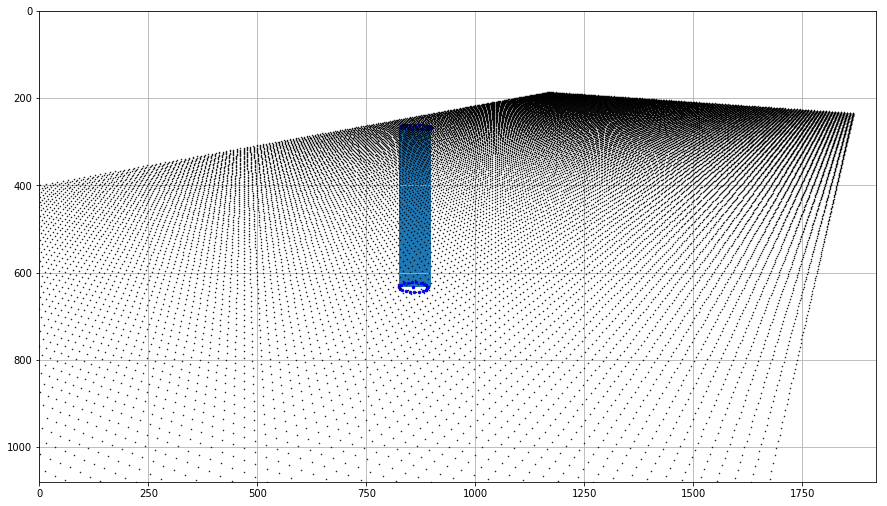

In [252]:
import matplotlib.patches as patches

camera = Camera(0, rvec, tvec, K, distCoeffs=np.zeros(5))
image_points = camera.project_points(world_grid)

cil = Cilinder(MAN_RAY, MAN_HEIGHT, world_grid[8000])
proj_points = camera.project_points(cil.get_points())  

rect = Rectangle(0, i, *cil.project(camera))
#rect = rectangles[0][8000]

fig1 = plt.figure(figsize=(15,15))
ax1 = fig1.add_subplot(111, aspect='equal')

xmin = rect.xmin
ymin = rect.ymin
xmax = rect.xmax
ymax = rect.ymax
'''
xmin = 812
ymin = 260
xmax = 910
ymax = 632
'''
ax1.add_patch(
    patches.Rectangle(
        (xmin, ymin), # (x,y)
        xmax-xmin,    # width
        ymax-ymin,    # height
    )
)
ax1.plot(proj_points[:,0], proj_points[:,1], 'b.', markersize=5)
ax1.plot(image_points[:,0], image_points[:,1], 'k.', markersize=1)
ax1.axis([0, 1920, 1080, 0])
ax1.grid()

## To compute the percentage of visible rectangle

Are they intersecting eachother? True
Percentage of intersection? 0.8


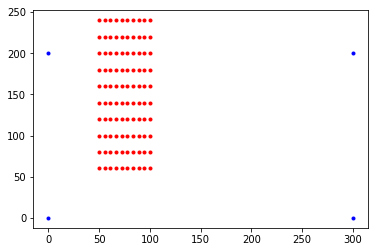

In [141]:
from matplotlib.path import Path

image_size = (200,300)
image_polygon = np.array([[0, 0],
                             [0, image_size[0]],
                             [image_size[1], image_size[0]],
                             [image_size[1], 0]])
img_path = Path(image_polygon)

rect_width = 50
rect_height = 180
rect_base_center = (50,60)
rect_polygon = np.array([[rect_base_center[0]-rect_width/2, rect_base_center[1]],
                              [rect_base_center[0]-rect_width/2, rect_base_center[1]+rect_height],
                              [rect_base_center[0]+rect_width/2, rect_base_center[1]+rect_height],
                              [rect_base_center[0]+rect_width/2, rect_base_center[1]]])

rect_path = Path(rect_polygon)

rect_grid = np.meshgrid(np.linspace(0, rect_width, 10), np.linspace(0, rect_height, 10))
rect_grid = np.vstack([rect_grid[0].ravel(), rect_grid[1].ravel()]).T + np.array(rect_base_center)

plt.figure()
plt.plot(image_polygon[:,0], image_polygon[:,1], 'b.')
plt.plot(rect_grid[:,0], rect_grid[:,1], 'r.')

print("Are they intersecting eachother?", img_path.intersects_path(rect_path))
print("Percentage of intersection?", img_path.contains_points(rect_grid).sum()/len(rect_grid))

Are they intersecting eachother? True
Percentage of intersection? 0.0


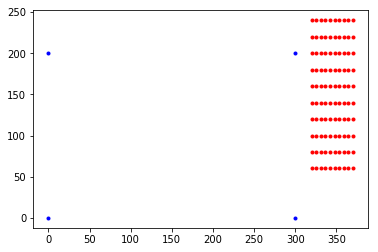

In [145]:
from matplotlib.path import Path

image_size = (200,300)
image_polygon = np.array([[0, 0],
                             [0, image_size[0]],
                             [image_size[1], image_size[0]],
                             [image_size[1], 0]])
img_path = Path(image_polygon)

rect_width = 50
rect_height = 180
rect_base_center = (320,60)
rect_polygon = np.array([[rect_base_center[0]-rect_width/2, rect_base_center[1]],
                              [rect_base_center[0]-rect_width/2, rect_base_center[1]+rect_height],
                              [rect_base_center[0]+rect_width/2, rect_base_center[1]+rect_height],
                              [rect_base_center[0]+rect_width/2, rect_base_center[1]]])

rect_path = Path(rect_polygon)

rect_grid = np.meshgrid(np.linspace(0, rect_width, 10), np.linspace(0, rect_height, 10))
rect_grid = np.vstack([rect_grid[0].ravel(), rect_grid[1].ravel()]).T + np.array(rect_base_center)

plt.figure()
plt.plot(image_polygon[:,0], image_polygon[:,1], 'b.')
plt.plot(rect_grid[:,0], rect_grid[:,1], 'r.')

print("Are they intersecting eachother?", img_path.intersects_path(rect_path))
print("Percentage of intersection?", img_path.contains_points(rect_grid).sum()/len(rect_grid))